In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [22]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import xarray as xr

import covid19

In [23]:
lut_path = 'UID_ISO_FIPS_LookUp_Table.csv'
# lut_path = covid19.data.download('LUT', repo='world')
lut_path

'UID_ISO_FIPS_LookUp_Table.csv'

In [24]:
deaths_path = 'time_series_covid19_deaths_global.csv'
deaths_path = covid19.data.download('deaths', repo='world')
confirmed_path = 'time_series_covid19_confirmed_global.csv'
confirmed_path = covid19.data.download('confirmed', repo='world')
deaths_path, confirmed_path

('time_series_covid19_deaths_global.csv',
 'time_series_covid19_confirmed_global.csv')

In [25]:
covid19.data.read_jhu_global(confirmed_path)

<xarray.Dataset>
Dimensions:       (location: 266, time: 221)
Coordinates:
    country       (location) <U32 'Afghanistan' 'Albania' ... 'Zimbabwe'
    lat           (location) float64 33.94 41.15 28.03 ... 15.55 -13.13 -19.02
    lon           (location) float64 67.71 20.17 1.66 ... 48.52 27.85 29.15
  * time          (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2020-08-29
  * location      (location) <U46 'Afghanistan' 'Albania' ... 'Zimbabwe'
    state_region  (location) <U46 'Afghanistan / ' ... 'Zimbabwe / '
Data variables:
    deaths        (time, location) int64 0 0 0 0 0 ... 21668 10 1946 11902 6406

In [26]:
world = covid19.data.read_jhu_global(deaths_path, lut_path=lut_path)
world['confirmed'] = covid19.data.read_jhu_global(confirmed_path)['deaths']

europe = world.sel(location=['Italy', 'United Kingdom', 'France', 'Spain', 'Belgium', 'Netherlands', 'Sweden', 'Ireland', 'Switzerland', 'Portugal', 'Germany']).sum('location')
europe['daily_deaths'] = europe['deaths'].diff('time')
print(europe)

world['daily_deaths'] = world['deaths'].diff('time')
world['daily_confirmed'] = world['confirmed'].diff('time')
world['mortality'] = world['deaths'] / world.population * 1_000_000
world['prevalence'] = world['confirmed'] / world.population * 1_000_000
world['daily_prevalence'] = world['daily_confirmed'] / world.population * 1_000_000
world['daily_mortality'] = world['daily_deaths'] / world.population * 1_000_000
world['daily_deaths7'] = world['daily_deaths'].rolling({'time': 7}).mean()
world['daily_mortality7'] = world['daily_mortality'].rolling({'time': 7}).mean()
world['daily_confirmed7'] = world['daily_confirmed'].rolling({'time': 7}).mean()
world['daily_prevalence7'] = world['daily_prevalence'].rolling({'time': 7}).mean()
world = world.drop(['lat', 'lon'])
world

<xarray.Dataset>
Dimensions:       (time: 221)
Coordinates:
  * time          (time) datetime64[ns] 2020-01-22 2020-01-23 ... 2020-08-29
Data variables:
    deaths        (time) int64 0 0 0 0 0 ... 173114 173088 173178 173242 173277
    confirmed     (time) int64 0 0 2 3 3 ... 1886135 1908212 1931159 1936336
    daily_deaths  (time) float64 nan 0.0 0.0 0.0 0.0 ... -26.0 90.0 64.0 35.0


<xarray.Dataset>
Dimensions:            (location: 266, time: 221)
Coordinates:
  * time               (time) datetime64[ns] 2020-01-22 ... 2020-08-29
    country            (location) <U32 'Afghanistan' 'Albania' ... 'Zimbabwe'
  * location           (location) <U46 'Afghanistan' 'Albania' ... 'Zimbabwe'
    state_region       (location) <U46 'Afghanistan / ' ... 'Zimbabwe / '
    population         (location) float64 3.893e+07 2.878e+06 ... 1.486e+07
Data variables:
    deaths             (time, location) int64 0 0 0 0 0 0 ... 147 1 563 284 196
    confirmed          (time, location) int64 0 0 0 0 0 ... 10 1946 11902 6406
    daily_deaths       (time, location) float64 nan nan nan nan ... 0.0 1.0 1.0
    daily_confirmed    (time, location) float64 nan nan nan ... 3.0 123.0 18.0
    mortality          (time, location) float64 0.0 0.0 0.0 ... 15.45 13.19
    prevalence         (time, location) float64 0.0 0.0 0.0 ... 647.4 431.0
    daily_prevalence   (time, location) float64 nan nan nan ... 6.691 1.211
    daily_mortality    (time, location) float64 nan nan nan ... 0.0544 0.06728
    daily_deaths7      (time, location) float64 nan nan nan ... 0.7143 6.143
    daily_mortality7   (time, location) float64 nan nan nan ... 0.03885 0.4133
    daily_confirmed7   (time, location) float64 nan nan nan ... 153.0 73.29
    daily_prevalence7  (time, location) float64 nan nan nan ... 8.322 4.931

In [27]:
world_latest = world.isel(time=-1)
world_latest = world_latest.sortby(-world_latest['daily_mortality7'])
world_latest.sortby(-world_latest['mortality']).to_dataframe().reset_index().head(50)

location       time                 country  \
0               San Marino 2020-08-29              San Marino   
1                     Peru 2020-08-29                    Peru   
2                  Belgium 2020-08-29                 Belgium   
3                  Andorra 2020-08-29                 Andorra   
4                    Spain 2020-08-29                   Spain   
5           United Kingdom 2020-08-29          United Kingdom   
6                    Italy 2020-08-29                   Italy   
7                    Chile 2020-08-29                   Chile   
8                   Sweden 2020-08-29                  Sweden   
9                   Brazil 2020-08-29                  Brazil   
10                      US 2020-08-29                      US   
11                  Mexico 2020-08-29                  Mexico   
12                  France 2020-08-29                  France   
13                  Panama 2020-08-29                  Panama   
14                 Bolivia 2020-08-29                 Bolivia   
15                Colombia 2020-08-29                Colombia   
16                 Ecuador 2020-08-29                 Ecuador   
17             Netherlands 2020-08-29             Netherlands   
18                 Ireland 2020-08-29                 Ireland   
19                 Armenia 2020-08-29                 Armenia   
20         North Macedonia 2020-08-29         North Macedonia   
21                  Kosovo 2020-08-29                  Kosovo   
22                    Iran 2020-08-29                    Iran   
23                 Moldova 2020-08-29                 Moldova   
24            South Africa 2020-08-29            South Africa   
25             Switzerland 2020-08-29             Switzerland   
26              Luxembourg 2020-08-29              Luxembourg   
27                Honduras 2020-08-29                Honduras   
28               Argentina 2020-08-29               Argentina   
29                 Romania 2020-08-29                 Romania   
30  Bosnia and Herzegovina 2020-08-29  Bosnia and Herzegovina   
31                Portugal 2020-08-29                Portugal   
32                    Iraq 2020-08-29                    Iraq   
33              Kyrgyzstan 2020-08-29              Kyrgyzstan   
34      Dominican Republic 2020-08-29      Dominican Republic   
35               Guatemala 2020-08-29               Guatemala   
36              Montenegro 2020-08-29              Montenegro   
37                    Oman 2020-08-29                    Oman   
38                 Bahamas 2020-08-29                 Bahamas   
39                  Kuwait 2020-08-29                  Kuwait   
40                  Russia 2020-08-29                  Russia   
41                Suriname 2020-08-29                Suriname   
42                 Bahrain 2020-08-29                 Bahrain   
43                 Germany 2020-08-29                 Germany   
44            Saudi Arabia 2020-08-29            Saudi Arabia   
45             El Salvador 2020-08-29             El Salvador   
46                 Denmark 2020-08-29                 Denmark   
47                  Israel 2020-08-29                  Israel   
48                  Monaco 2020-08-29                  Monaco   
49                 Albania 2020-08-29                 Albania   

                 state_region   population  deaths  confirmed  daily_deaths  \
0               San Marino /       33938.0      42        710           0.0   
1                     Peru /    32971846.0   28471     629961         194.0   
2                  Belgium /    11589616.0    9891      84599           5.0   
3                  Andorra /       77265.0      53       1124           0.0   
4                    Spain /    46754783.0   29011     439286           0.0   
5           United Kingdom /    67886004.0   41498     332752          12.0   
6                    Italy /    60461828.0   35473     266853           1.0   
7                    Chile /    19116209.0   11181     408009         

In [28]:
world_latest.to_dataframe().reset_index().head(60)

location       time                 country  \
0                  Bahamas 2020-08-29                 Bahamas   
1                 Colombia 2020-08-29                Colombia   
2                  Bolivia 2020-08-29                 Bolivia   
3                     Peru 2020-08-29                    Peru   
4                Argentina 2020-08-29               Argentina   
5                   Brazil 2020-08-29                  Brazil   
6                   Mexico 2020-08-29                  Mexico   
7                   Panama 2020-08-29                  Panama   
8                   Kosovo 2020-08-29                  Kosovo   
9                    Chile 2020-08-29                   Chile   
10                Honduras 2020-08-29                Honduras   
11                      US 2020-08-29                      US   
12  Bosnia and Herzegovina 2020-08-29  Bosnia and Herzegovina   
13                  Belize 2020-08-29                  Belize   
14                Suriname 2020-08-29                Suriname   
15            South Africa 2020-08-29            South Africa   
16                 Romania 2020-08-29                 Romania   
17         North Macedonia 2020-08-29         North Macedonia   
18                 Ecuador 2020-08-29                 Ecuador   
19              Montenegro 2020-08-29              Montenegro   
20                Paraguay 2020-08-29                Paraguay   
21              Costa Rica 2020-08-29              Costa Rica   
22                 Moldova 2020-08-29                 Moldova   
23                    Iraq 2020-08-29                    Iraq   
24      Dominican Republic 2020-08-29      Dominican Republic   
25                 Albania 2020-08-29                 Albania   
26                    Iran 2020-08-29                    Iran   
27                  Israel 2020-08-29                  Israel   
28                Bulgaria 2020-08-29                Bulgaria   
29                 Namibia 2020-08-29                 Namibia   
30             El Salvador 2020-08-29             El Salvador   
31               Guatemala 2020-08-29               Guatemala   
32                    Oman 2020-08-29                    Oman   
33                 Armenia 2020-08-29                 Armenia   
34                Eswatini 2020-08-29                Eswatini   
35            Saudi Arabia 2020-08-29            Saudi Arabia   
36                   Libya 2020-08-29                   Libya   
37                 Morocco 2020-08-29                 Morocco   
38                 Ukraine 2020-08-29                 Ukraine   
39              Kazakhstan 2020-08-29              Kazakhstan   
40                  Guyana 2020-08-29                  Guyana   
41                 Lebanon 2020-08-29                 Lebanon   
42                  Gambia 2020-08-29                  Gambia   
43                   India 2020-08-29                   India   
44                  Russia 2020-08-29                  Russia   
45      West Bank and Gaza 2020-08-29      West Bank and Gaza   
46     Trinidad and Tobago 2020-08-29     Trinidad and Tobago   
47             Philippines 2020-08-29             Philippines   
48                   Spain 2020-08-29                   Spain   
49                Maldives 2020-08-29                Maldives   
50                 Belarus 2020-08-29                 Belarus   
51              Cabo Verde 2020-08-29              Cabo Verde   
52                 Bahrain 2020-08-29                 Bahrain   
53                  Kuwait 2020-08-29                  Kuwait   
54                 Croatia 2020-08-29                 Croatia   
55                Zimbabwe 2020-08-29                Zimbabwe   
56               Indonesia 2020-08-29               Indonesia   
57                Portugal 2020-08-29                Portugal   
58                  Turkey 2020-08-29                  Turkey   
59                  Poland 2020-08-29                  Poland   

                 state_region    population  deaths 

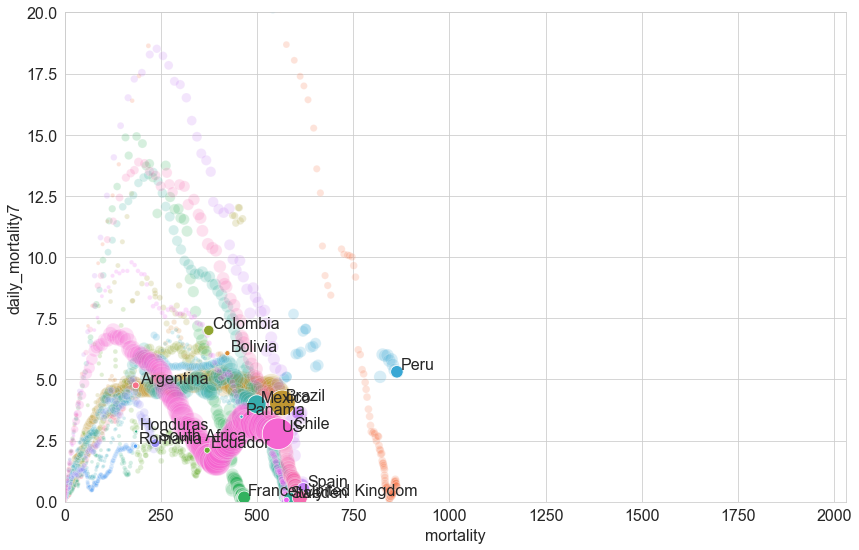

In [29]:
import seaborn as sns
# sns.set()
world_hit = world.sel(location=(((world['daily_mortality7'].isel(time=-1) > 2.) | (world['mortality'] > 400).any('time')) & (world['deaths'] > 1000)).any('time')).to_dataframe().reset_index()
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(x="mortality", y="daily_mortality7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 20), xlim=(0, 2030))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    if record['daily_mortality7'] > 20:
        continue
    ax.annotate(record['location'], (record['mortality'] + 10, record['daily_mortality7'] + .1))

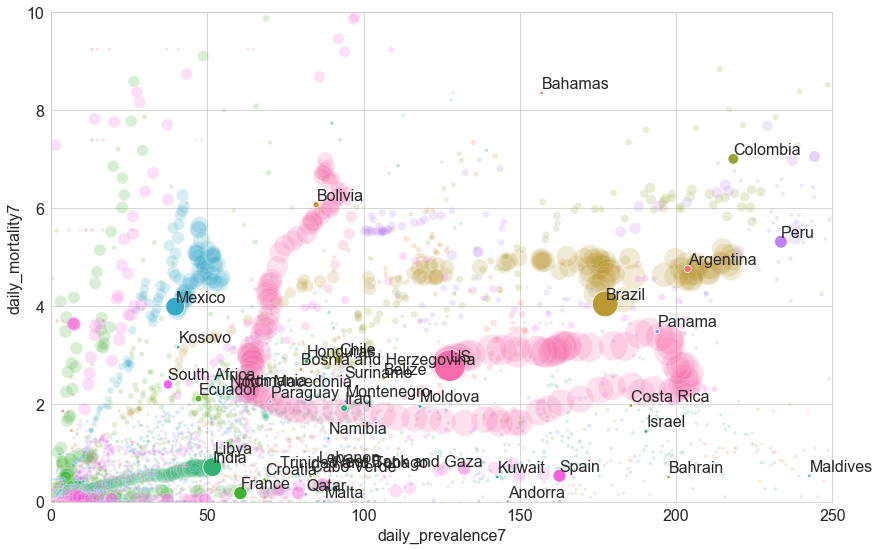

In [30]:
import seaborn as sns
# sns.set()
world_hit = world.sel(location=(((world['daily_prevalence7'].isel(time=-1) > 50.) | (world['daily_mortality7'].isel(time=-1) > 2.)) & (world['deaths'] > 0.)).any('time')).to_dataframe().reset_index()
ax = sns.scatterplot(y="daily_mortality7", x="daily_prevalence7", hue="location", size="deaths", data=world_hit, alpha=0.2, sizes=(10, 1_000), legend=False)
ax = sns.scatterplot(y="daily_mortality7", x="daily_prevalence7", hue="location", size="deaths", data=world_hit[world_hit['time']==world_hit['time'].max()], sizes=(10, 1_000), legend=False)
_ = ax.set(ylim=(0, 10), xlim=(0, 250))
for index in world_hit[world_hit['time']==world_hit['time'].max()].index:
    record = world_hit.loc[index]
    if record['daily_prevalence7'] > 250 or record['daily_mortality7'] > 10:
        continue
    ax.annotate(record['location'], (record['daily_prevalence7'] + .1, record['daily_mortality7'] + .1))

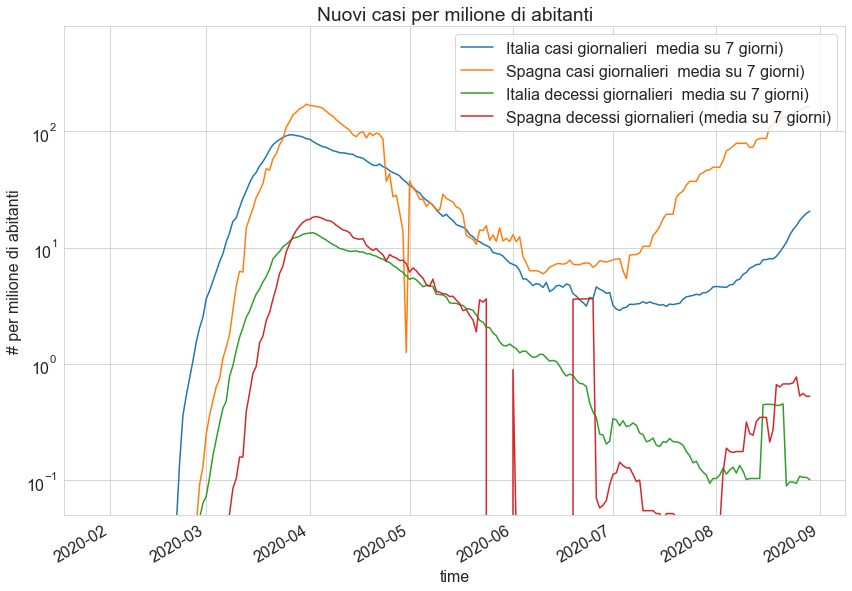

In [44]:
#world.sel(location='Spain')['daily_confirmed7'].plot(label='Nuovi casi giornalieri (media su 7 giorni)')
#world.sel(location='Greece')['daily_prevalence7'].plot(label='Greece')
#world.sel(location='Croatia')['daily_prevalence7'].plot(label='Croatia')
#world.sel(location='Malta')['daily_prevalence7'].plot(label='Malta')
#world.sel(location='Spain')['daily_prevalence7'].plot(label='Spain')
#world.sel(location='US')['daily_prevalence7'].plot(label='US')
#world.sel(location='Korea, South')['daily_deaths7'].plot(label='SK')
#world.sel(location='Korea, South')['daily_prevalence7'].plot(label='Corea del Sud')
world.sel(location='Italy')['daily_prevalence7'].plot(label='Italia casi giornalieri  media su 7 giorni)')
world.sel(location='Spain')['daily_prevalence7'].plot(label='Spagna casi giornalieri  media su 7 giorni)')
world.sel(location='Italy')['daily_mortality7'].plot(label='Italia decessi giornalieri  media su 7 giorni)')
world.sel(location='Spain')['daily_mortality7'].plot(label='Spagna decessi giornalieri (media su 7 giorni)')
#world.sel(location='US')['daily_prevalence7'].plot(label='US')
plt.legend()
plt.ylim(0.05, 800)
plt.yscale('log')
plt.ylabel('# per milione di abitanti')
_ = plt.title("Nuovi casi per milione di abitanti")

In [32]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

SHOWUNTIL = np.datetime64(world.time.values[-1], 's') + 10 * DAY

EXTENT = ('2020-02-20', SHOWUNTIL)
XLIM = tuple(map(np.datetime64, EXTENT))
XLIM_S = tuple([np.datetime64(d) + 10 * DAY for d in EXTENT])

In [33]:
PARAMS = {
    'China / Hubei': -36,
    'Iran': -2,
    'Korea, South': -1,
    'Italy': 0,
#     'EU': 0,
    'Spain': 5,
    'France': 11,
    'US': 12,
    'Japan': 13,
    'United Kingdom': 14,
    'Netherlands': 16,
    'Germany': 18,
    'Switzerland': 18,
    'Philippines': 18,
    'Indonesia': 19,
    'Belgium': 20,
    'Turkey': 21,
    'Brazil': 21,
    'Sweden': 23,
    'Algeria': 23,
    'Austria': 24,
    'Portugal': 24,
    'Ecuador': 24,
    'India': 29,
    'Canada / Ontario': 29,
    'Canada / Quebec': 30,
    'Mexico': 31,
    'Russia': 33,
}

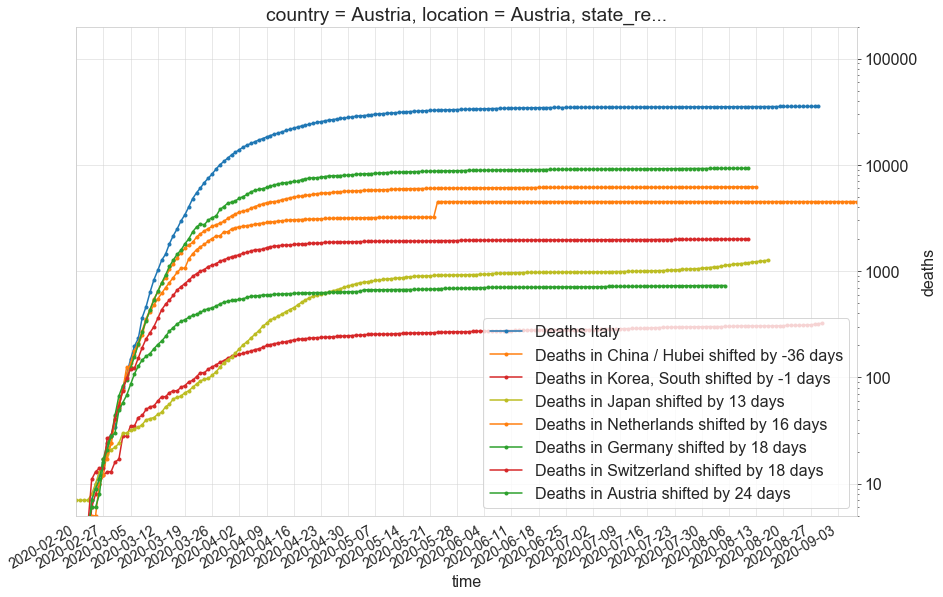

In [34]:
_, ax = covid19.plot.subplots(subplot_kw={'yscale': 'log', 'ylim': (5, 200000), 'xlim': XLIM}, figsize=(14, 9))
covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[1:])):
    if country not in ['Germany', 'Switzerland', 'Austria', 'Netherlands', 'Korea, South', 'Japan', 'China / Hubei']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color)
_ = ax.legend()

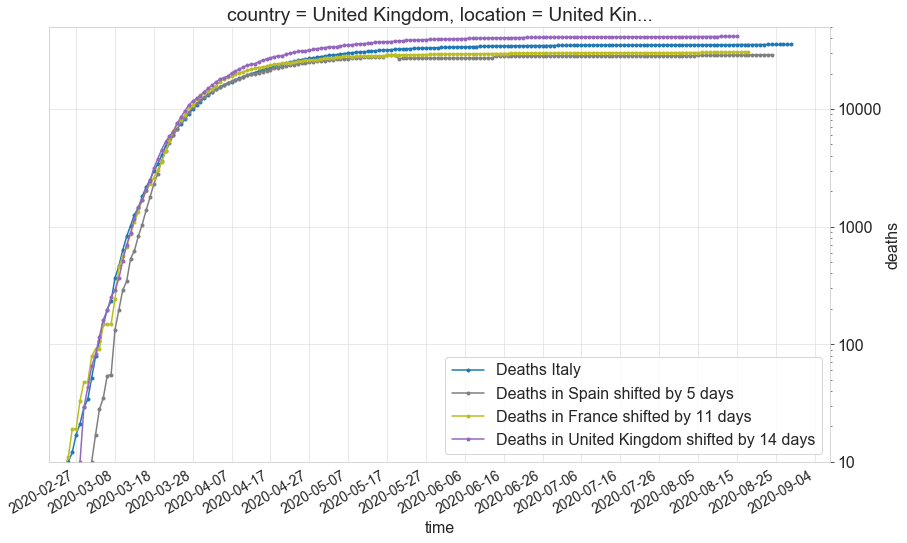

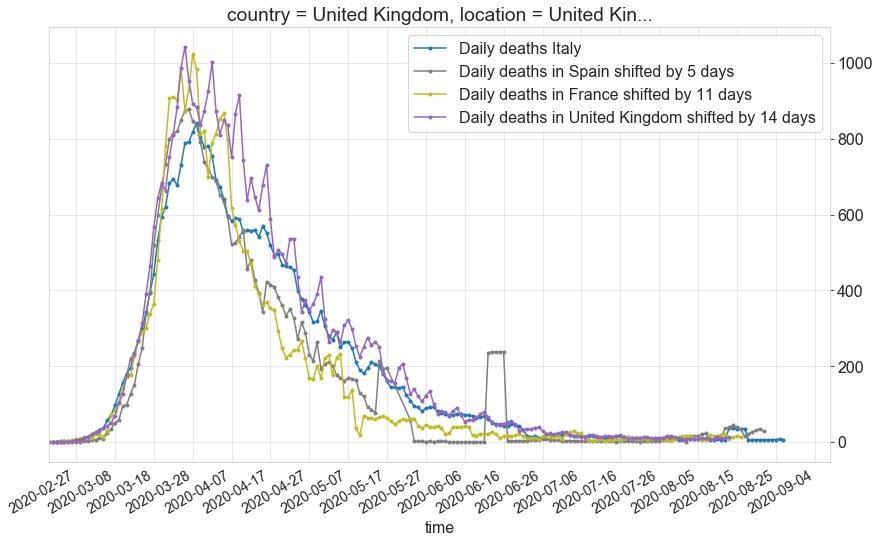

In [35]:
_, ax = covid19.plot.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (10, 50000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': XLIM
}, figsize=(14, 8))
_, ax1 = covid19.plot.subplots(subplot_kw={
    'xlim': XLIM
}, figsize=(14, 8))

covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0])
covid19.plot.plot_data(ax1, world.sel(location='Italy')['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths Italy', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['France', 'United Kingdom', 'Spain']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
    covid19.plot.plot_data(ax1, world.sel(location=country)['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
_ = ax.legend()
_ = ax1.legend()

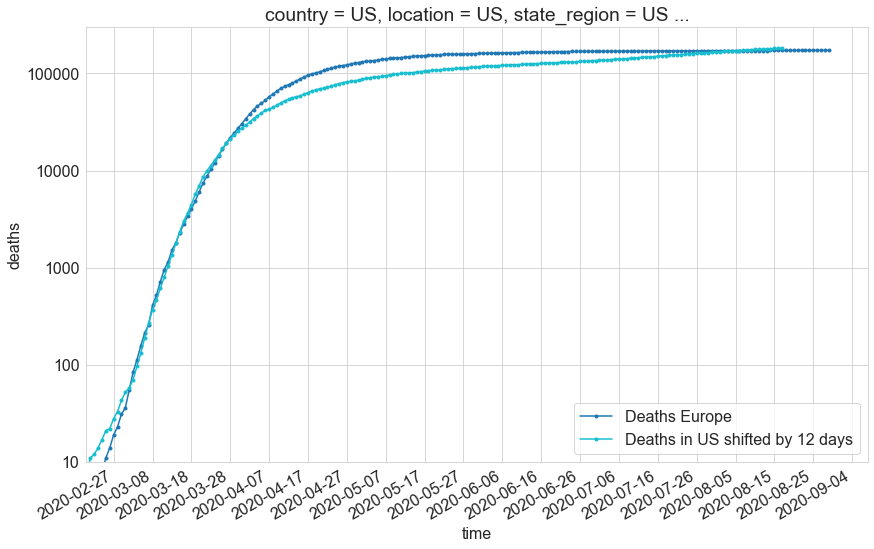

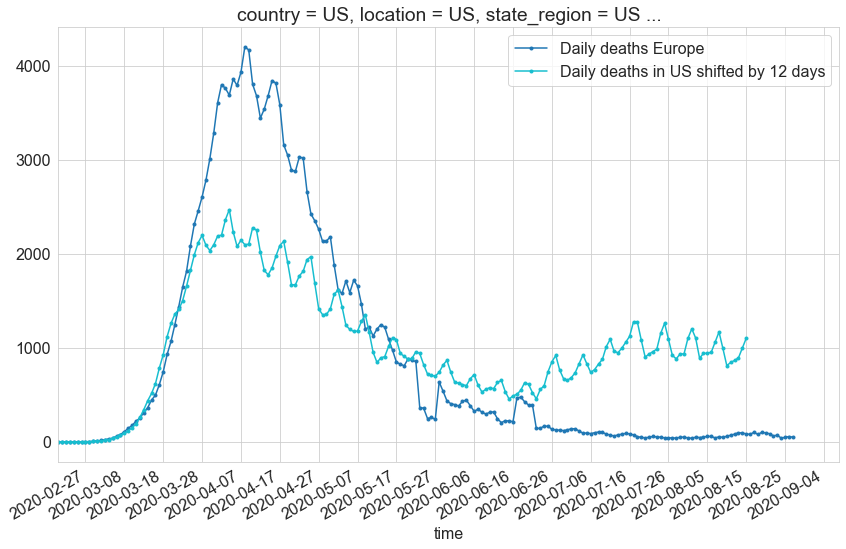

In [36]:
_, ax = plt.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (10, 300000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': XLIM
}, figsize=(14, 8))
_, ax1 = plt.subplots(subplot_kw={
    'xlim': XLIM
}, figsize=(14, 8))

covid19.plot.plot_data(ax, europe['deaths'], label=f'Deaths Europe', color=PALETTE_ONE[0])
covid19.plot.plot_data(ax1, europe['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths Europe', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['US']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
    covid19.plot.plot_data(ax1, world.sel(location=country)['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
_ = ax.legend()
_ = ax1.legend()

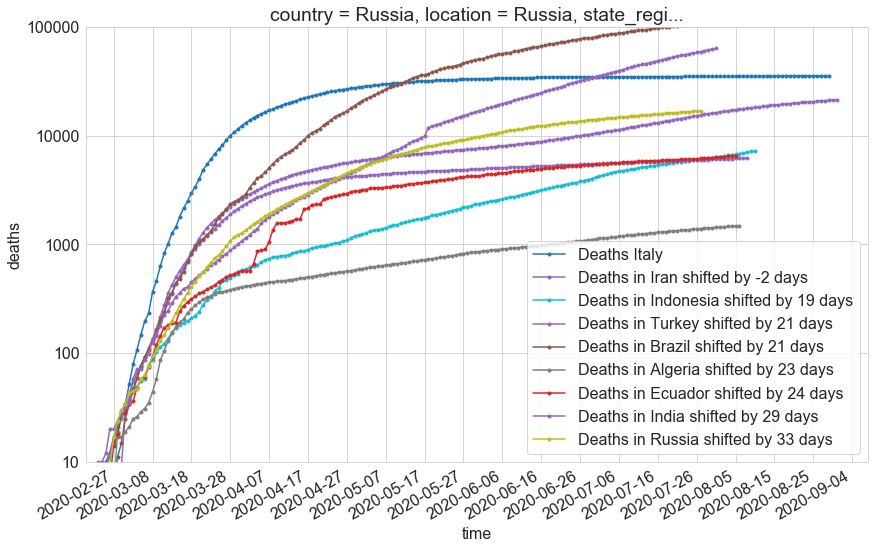

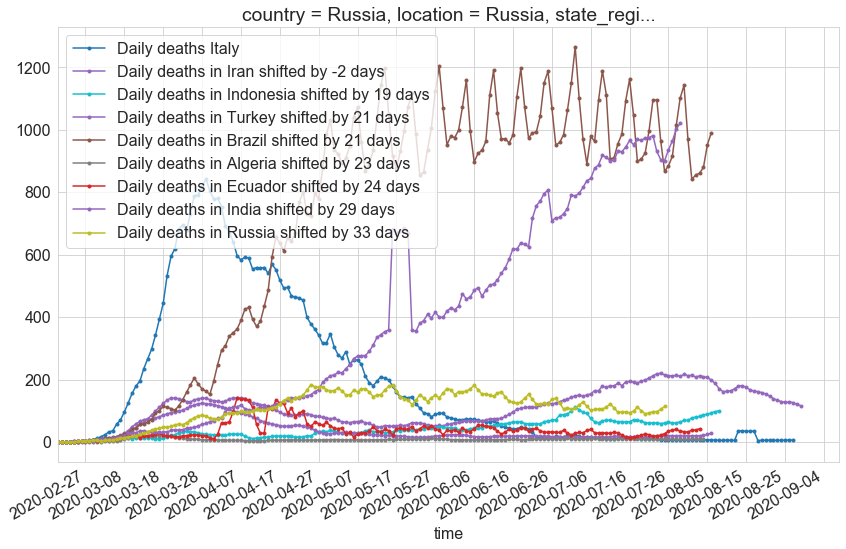

In [37]:
_, ax = plt.subplots(subplot_kw={
    'yscale': 'log',
    'ylim': (10, 100000),
    # 'ylim': (0, country_data['France']['deaths'].max() * 1.1),
    'xlim': XLIM
}, figsize=(14, 8))
_, ax1 = plt.subplots(subplot_kw={
    'xlim': XLIM
}, figsize=(14, 8))

covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths Italy', color=PALETTE_ONE[0])
covid19.plot.plot_data(ax1, world.sel(location='Italy')['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths Italy', color=PALETTE_ONE[0])
for (country, delay), color in zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[3:])):
    if country not in ['Iran', 'Brazil', 'Turkey', 'India', 'Indonesia', 'Ecuador', 'Algeria', 'Russia']:
        continue
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
    covid19.plot.plot_data(ax1, world.sel(location=country)['daily_deaths'].rolling({'time': 5}, center=True).mean(), label=f'Daily deaths in {country} shifted by {delay} days', delay=-delay, color=color, date_interval=10)
_ = ax.legend()
_ = ax1.legend()

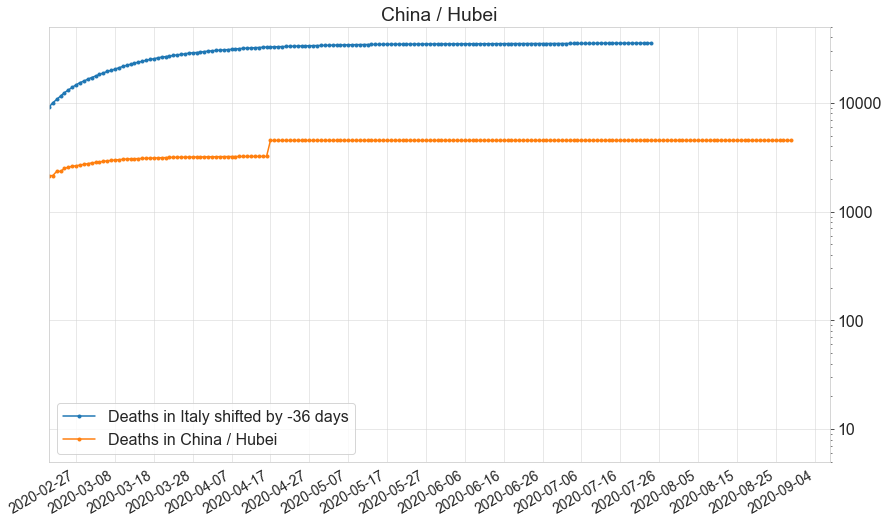

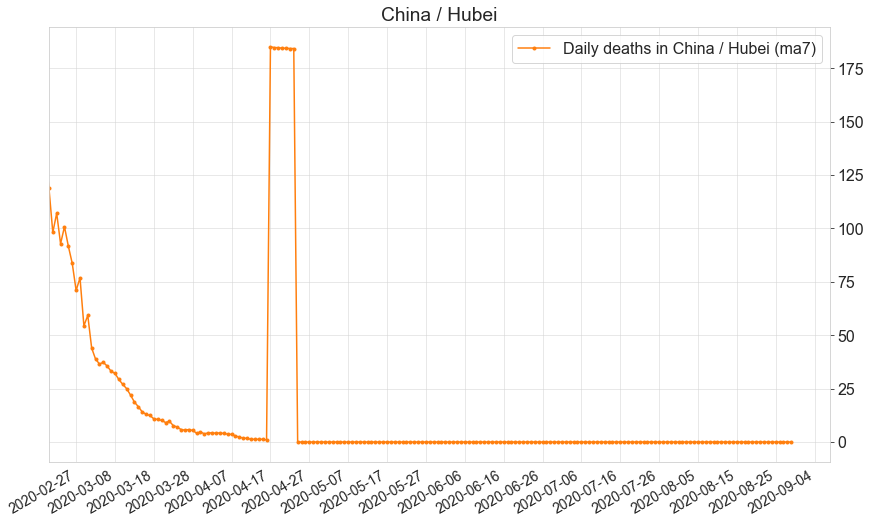

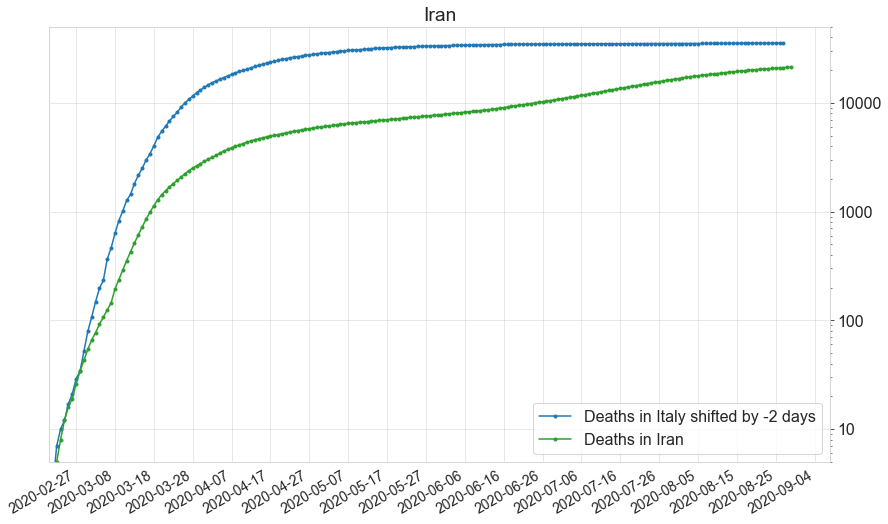

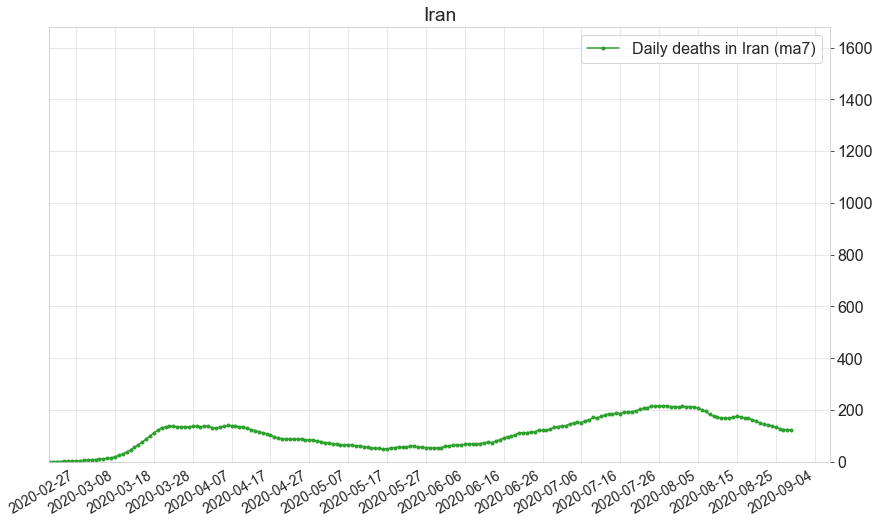

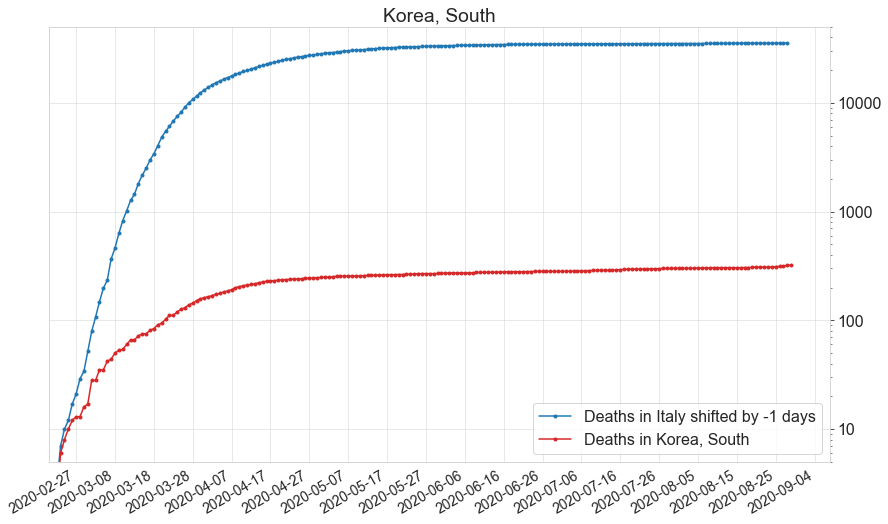

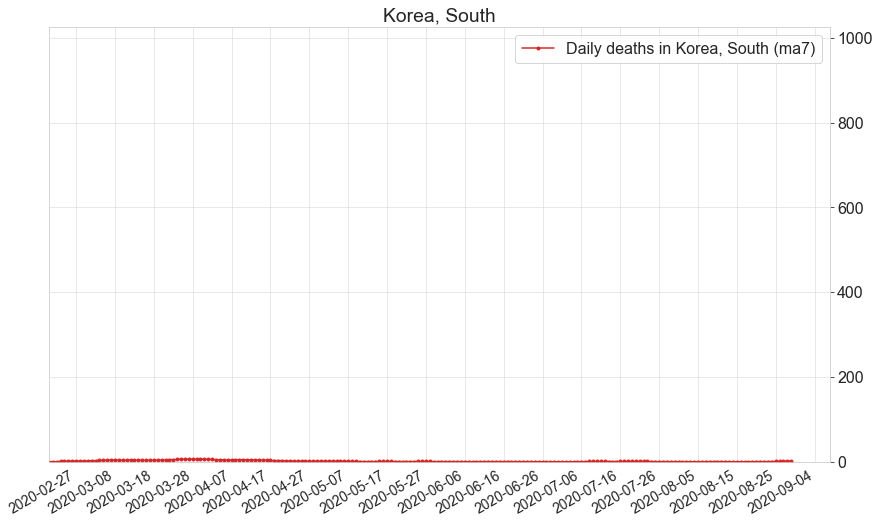

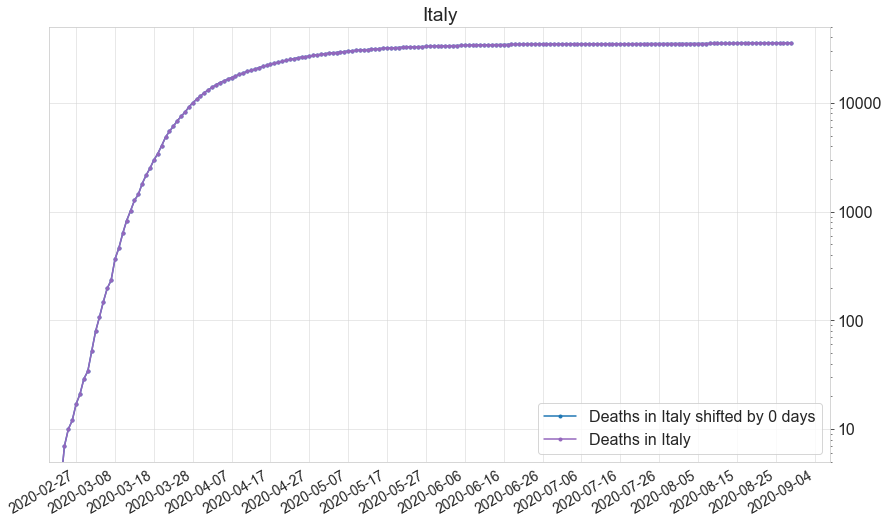

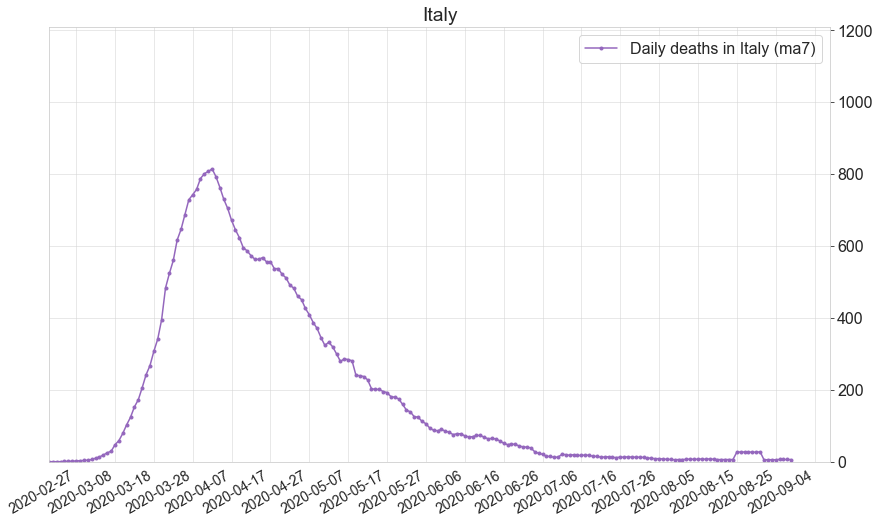

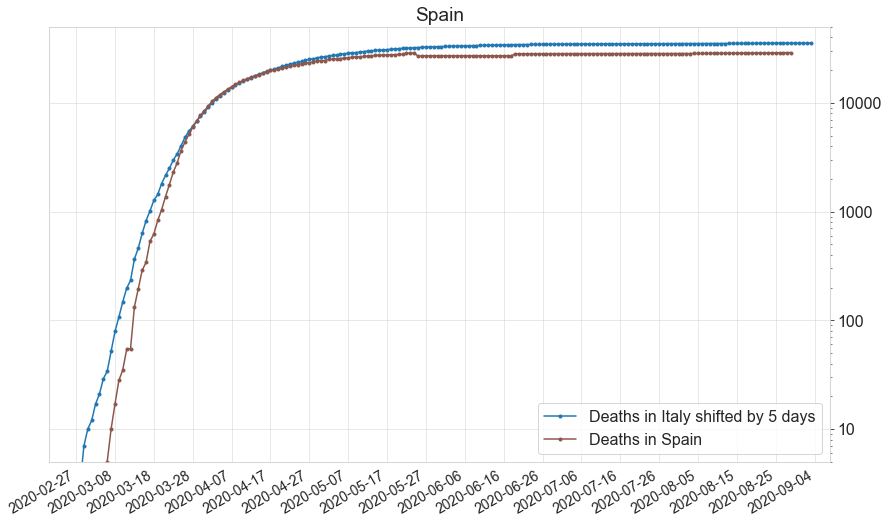

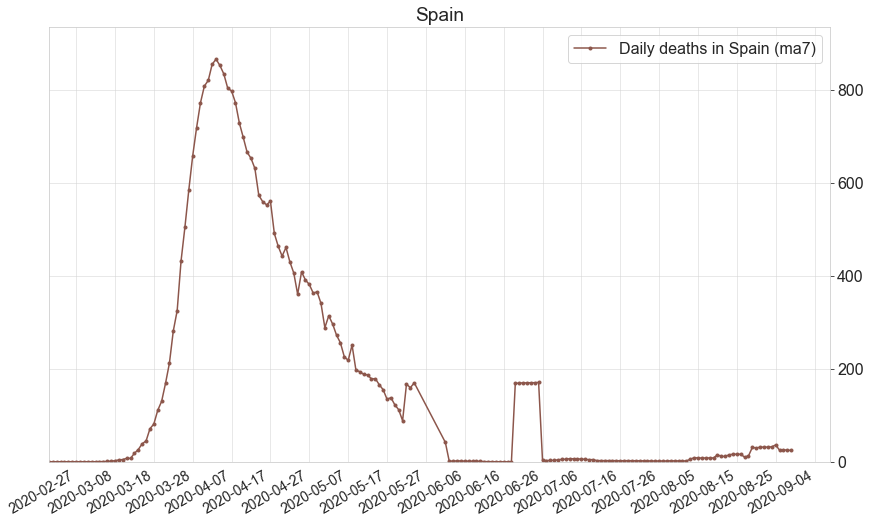

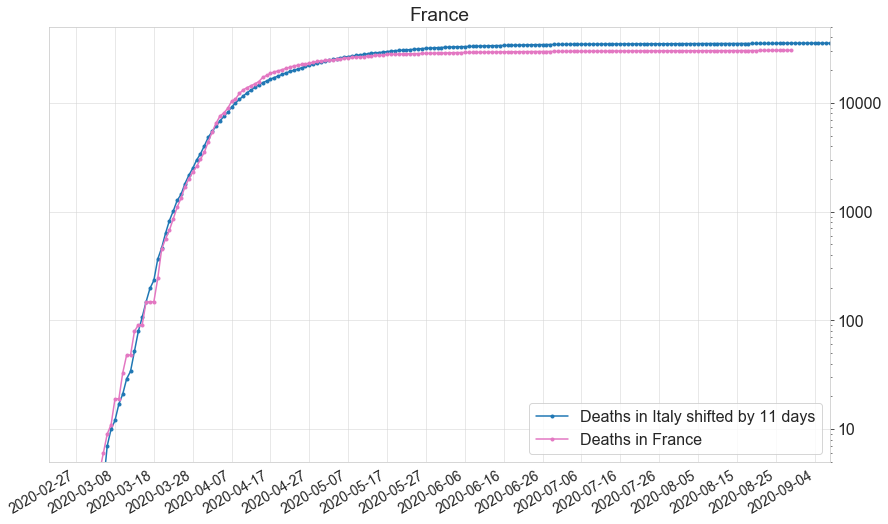

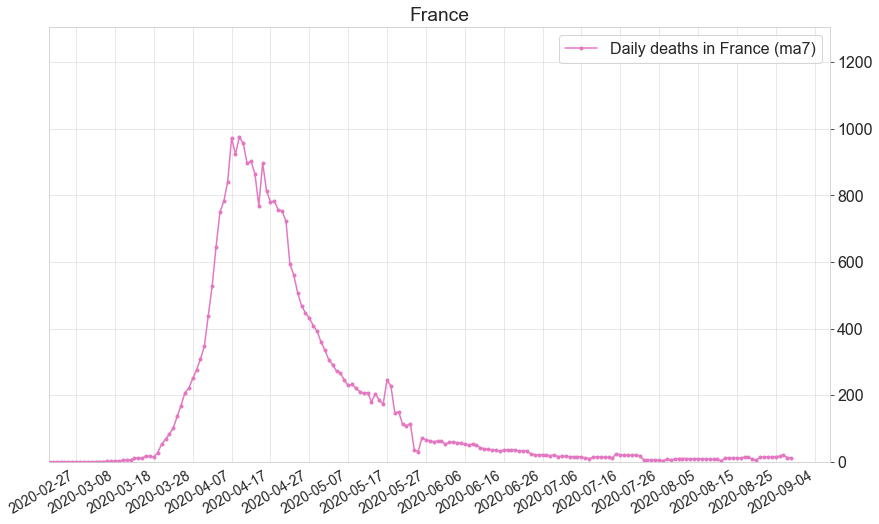

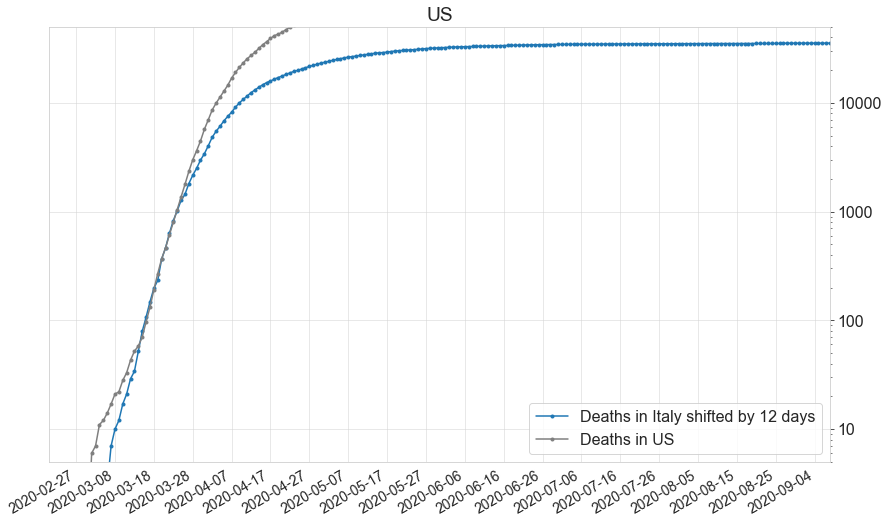

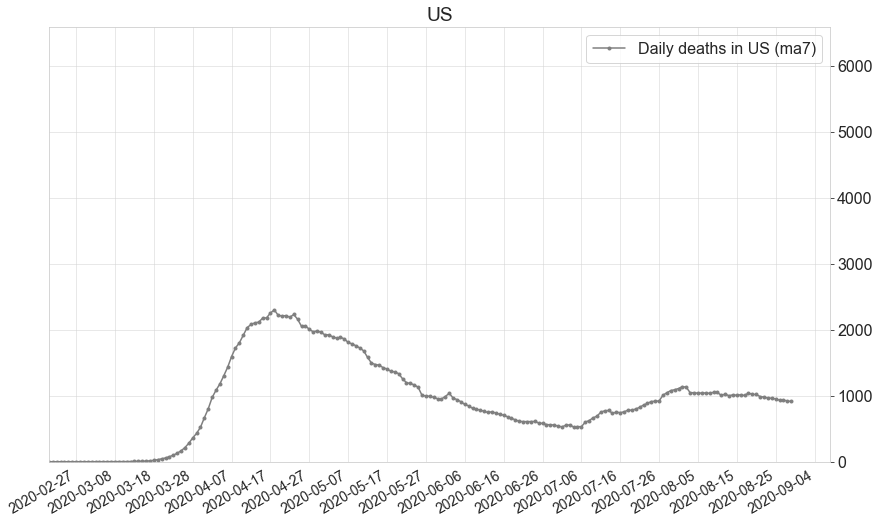

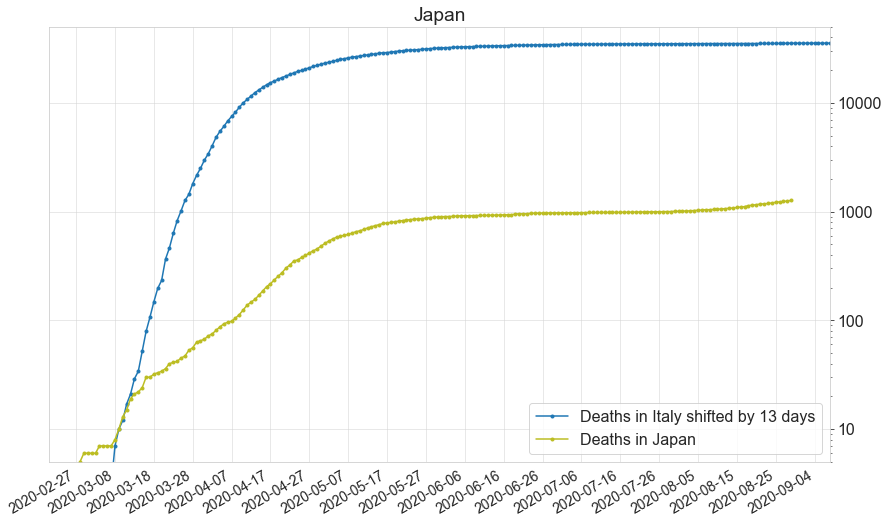

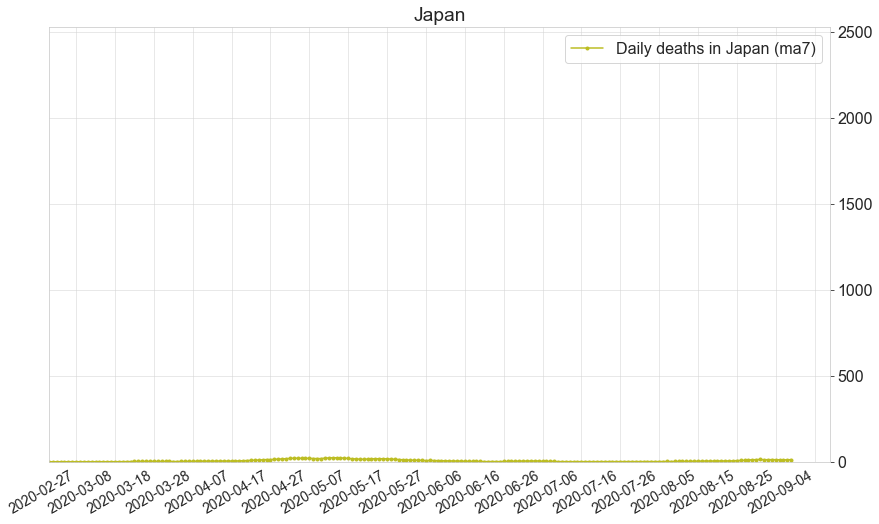

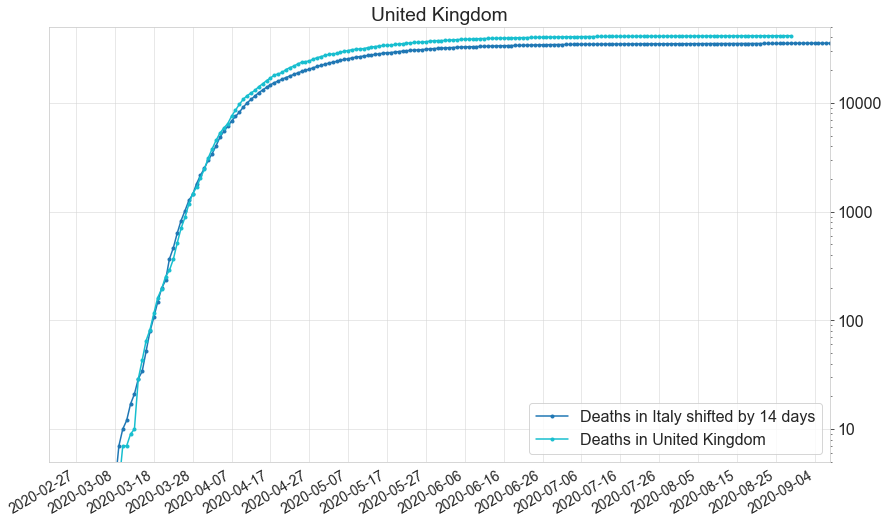

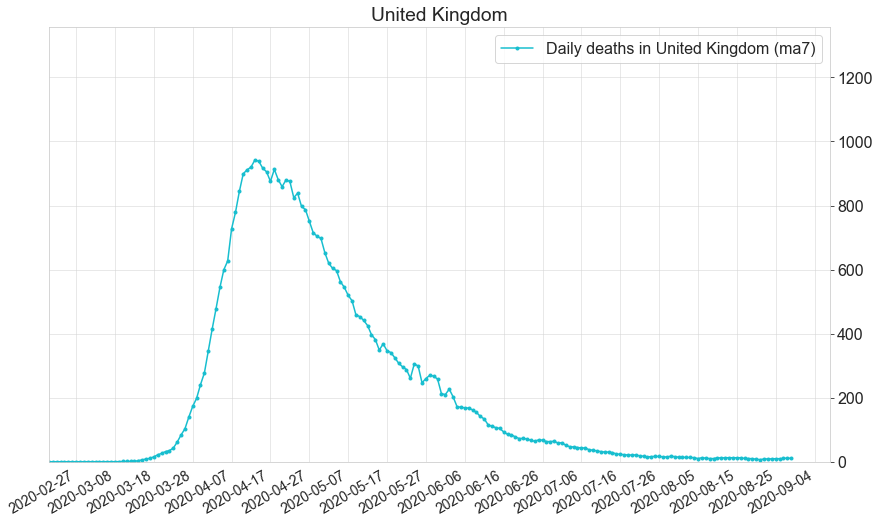

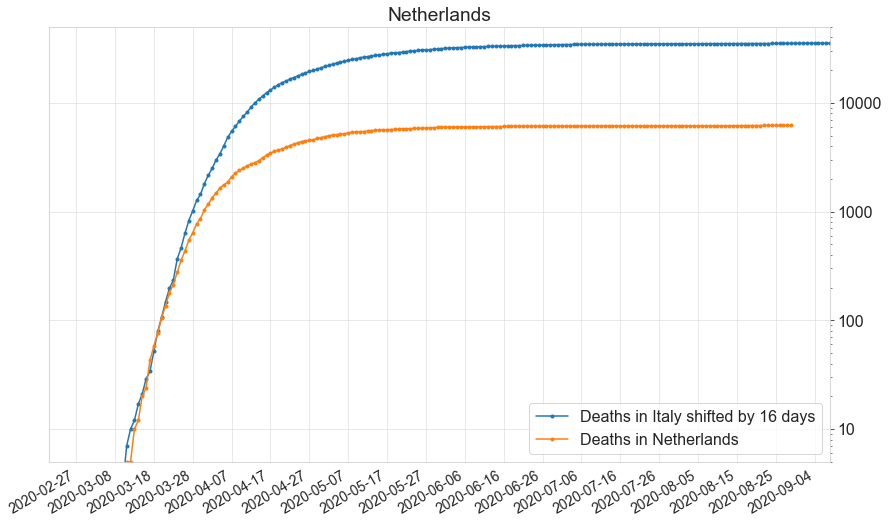

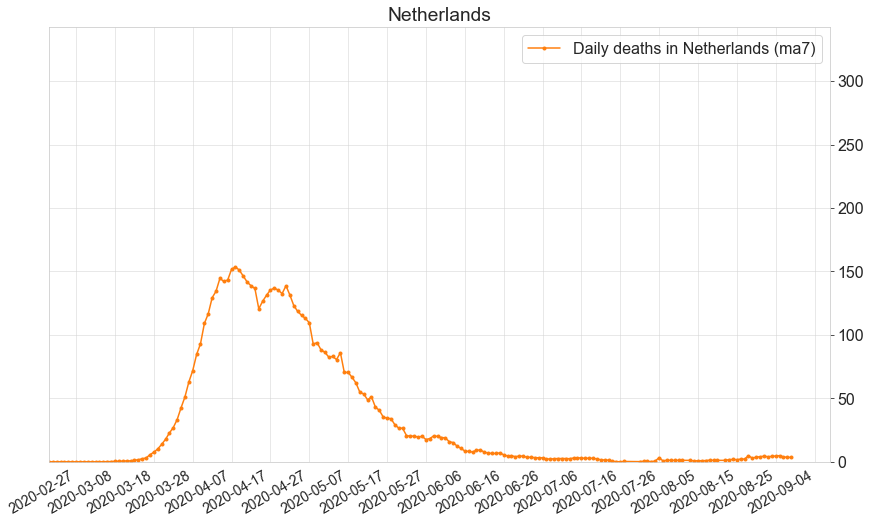

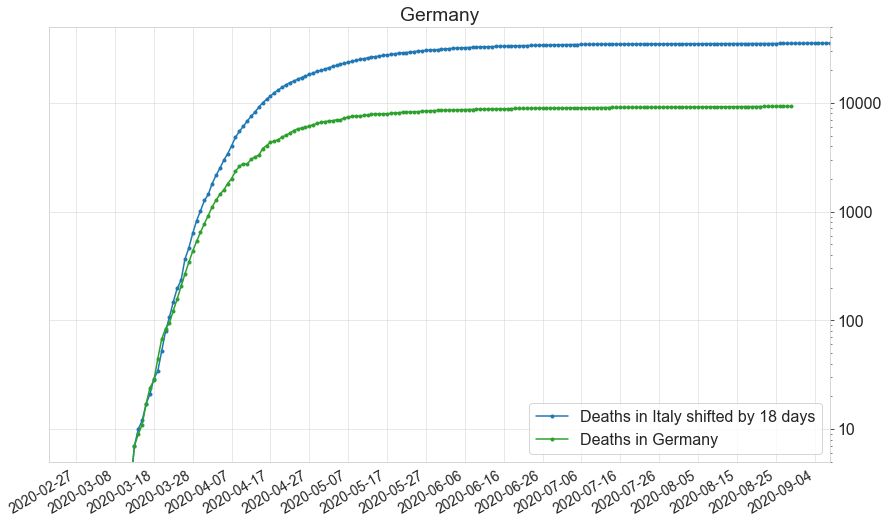

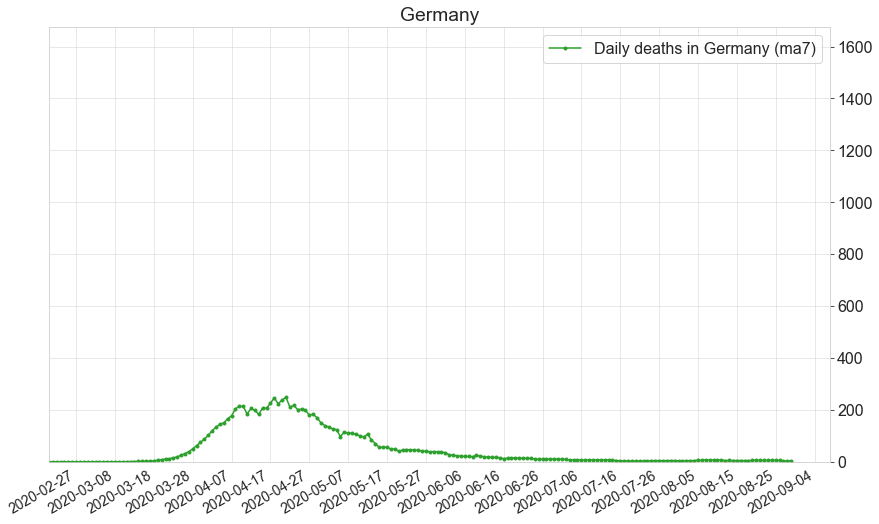

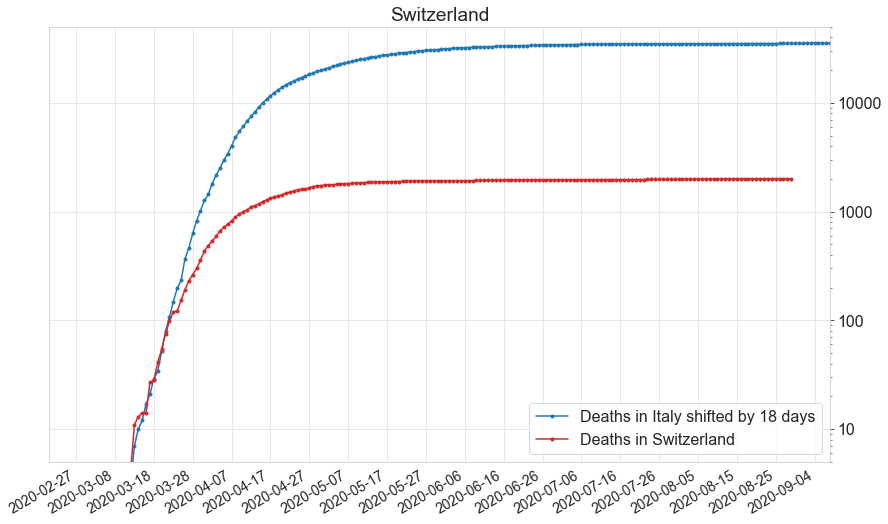

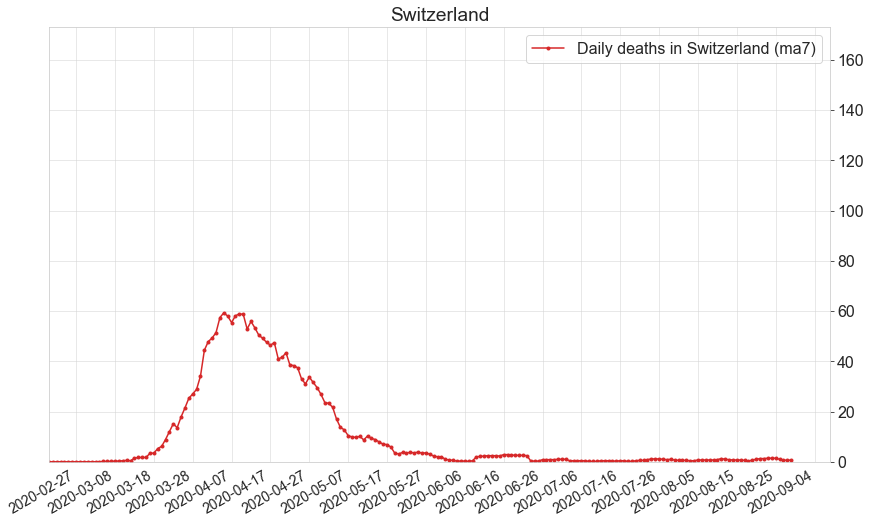

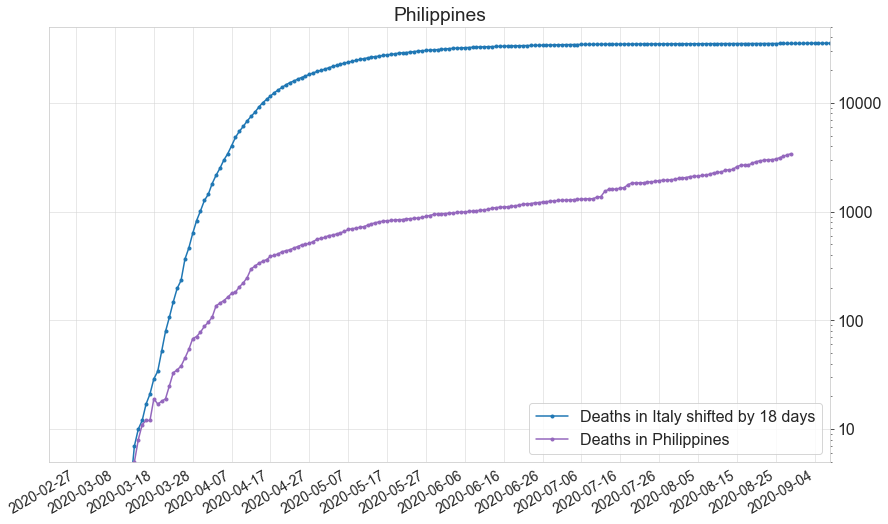

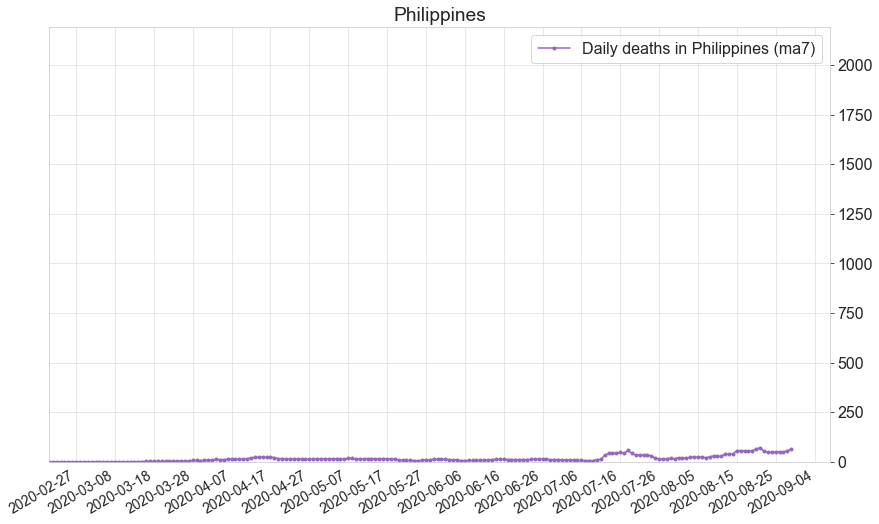

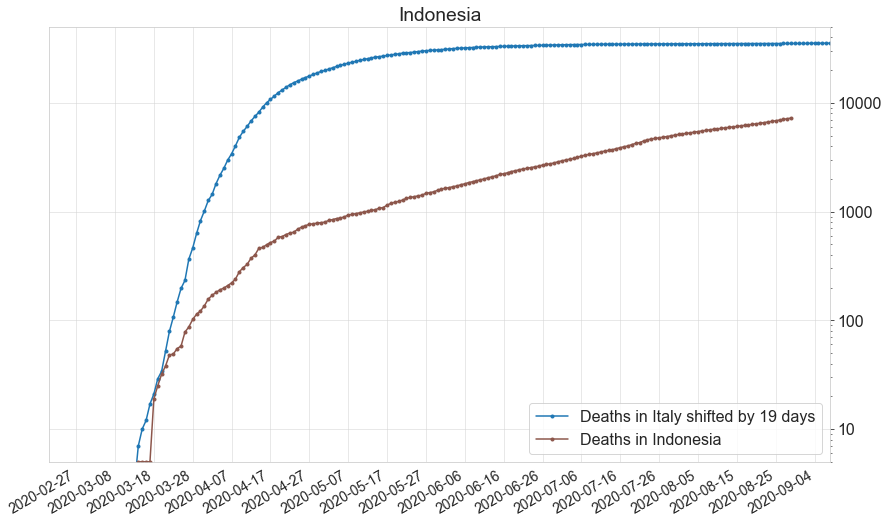

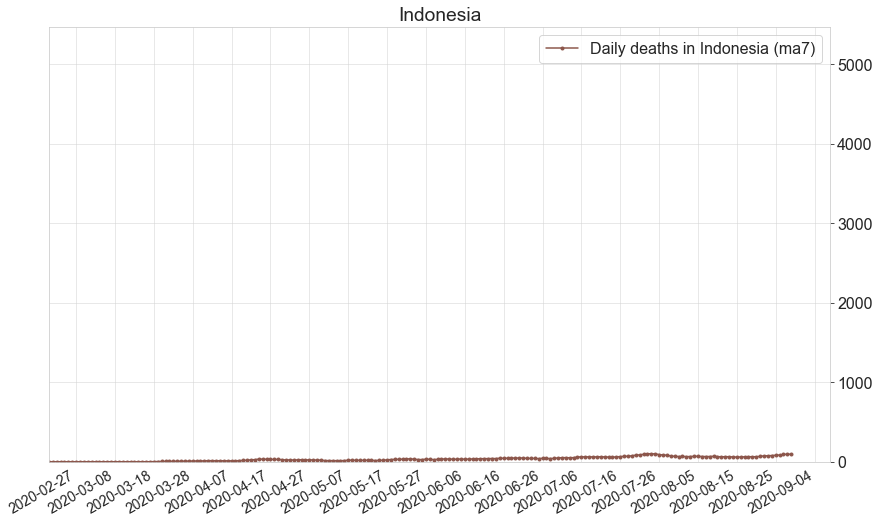

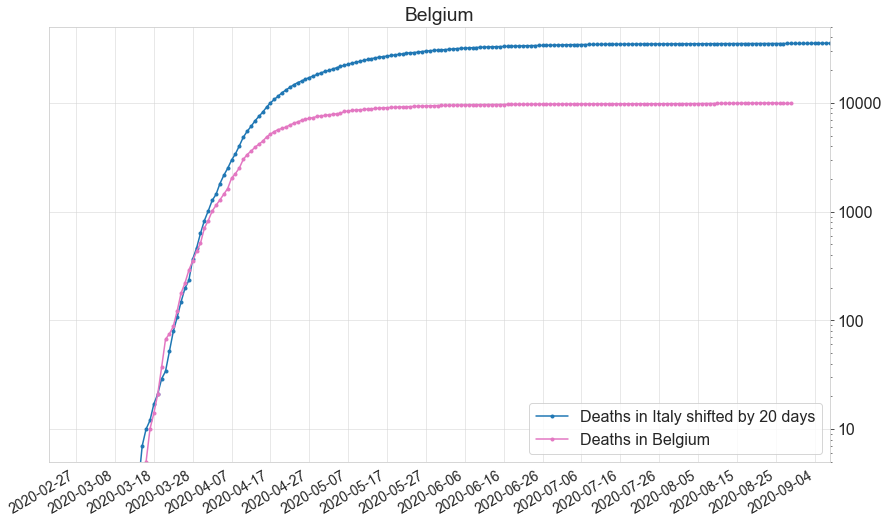

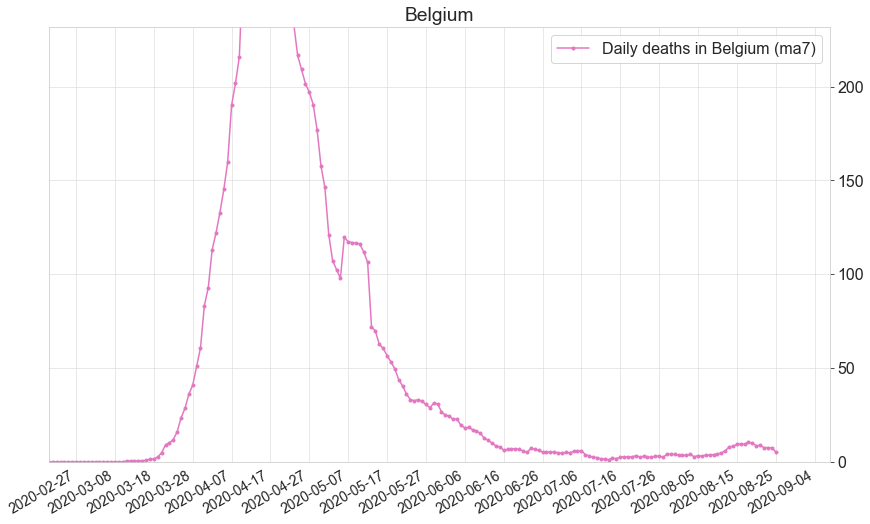

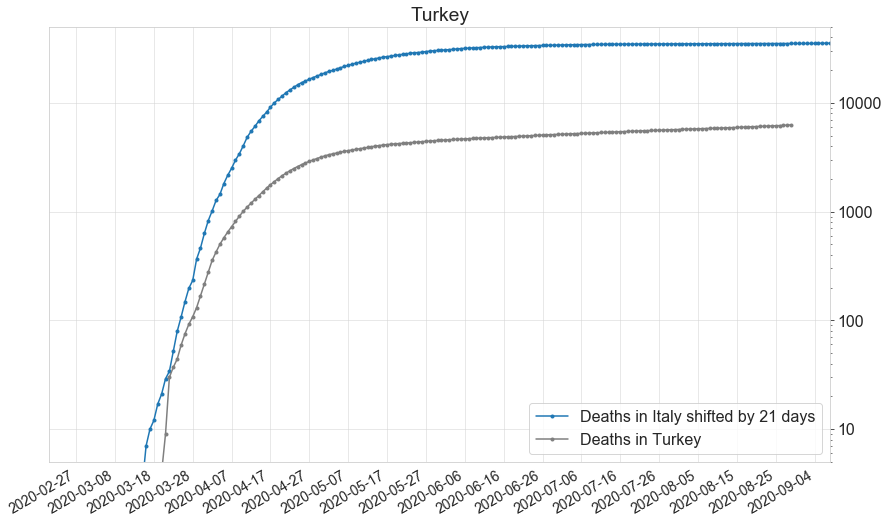

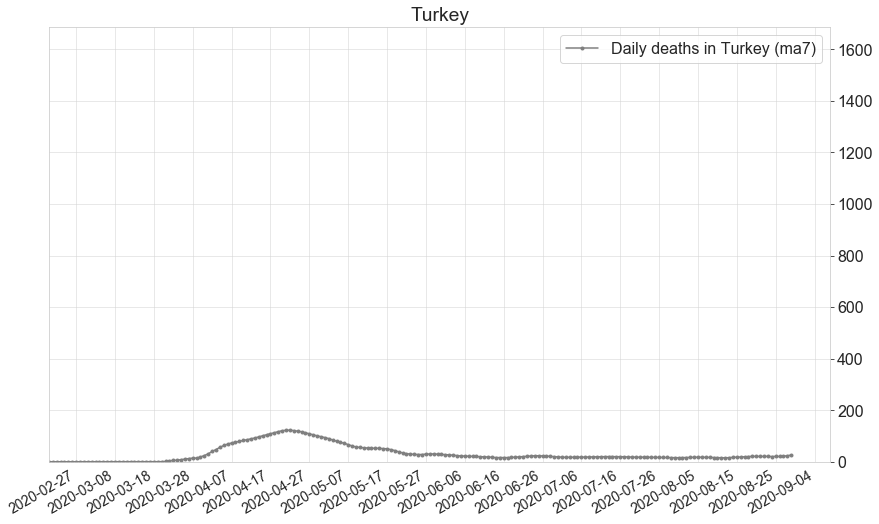

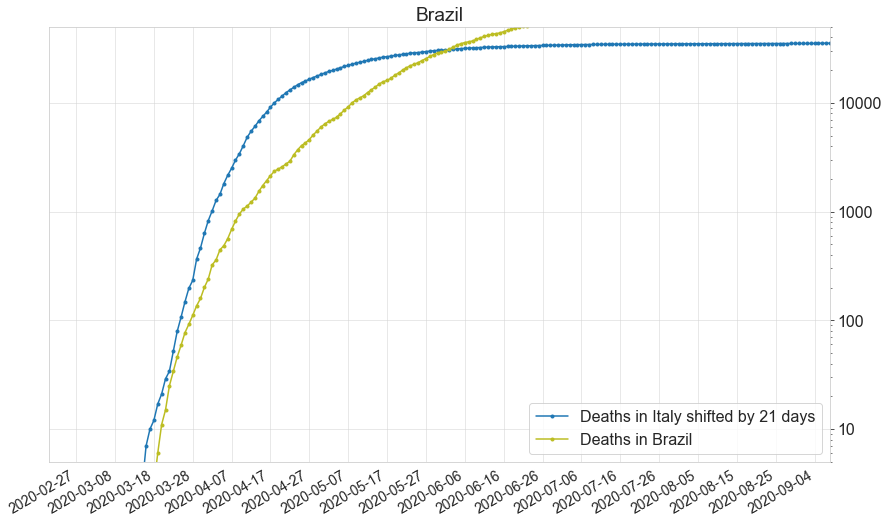

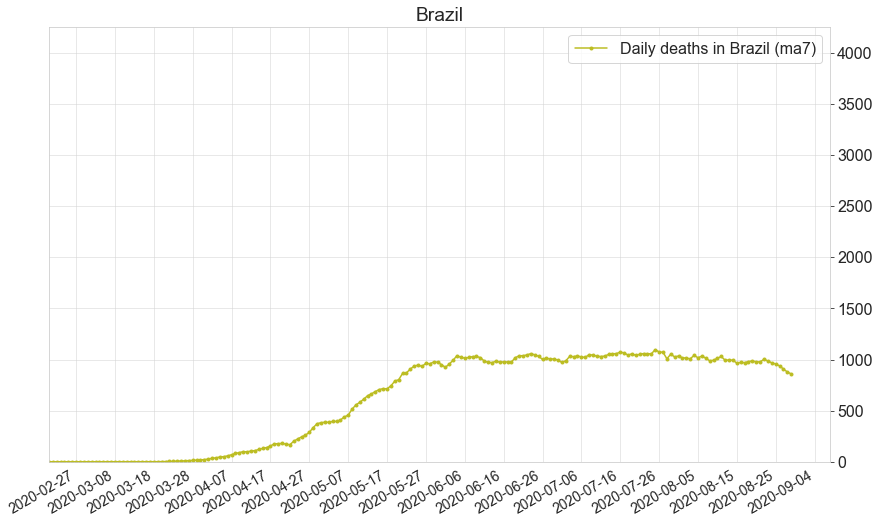

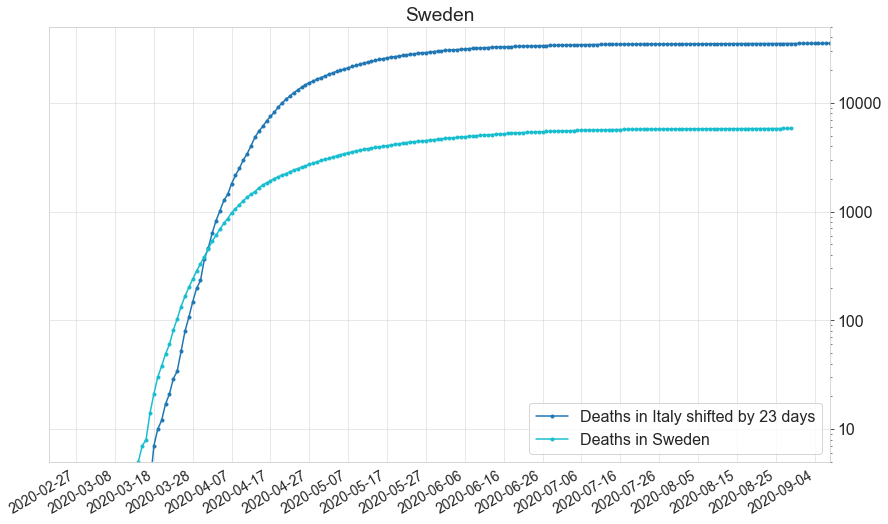

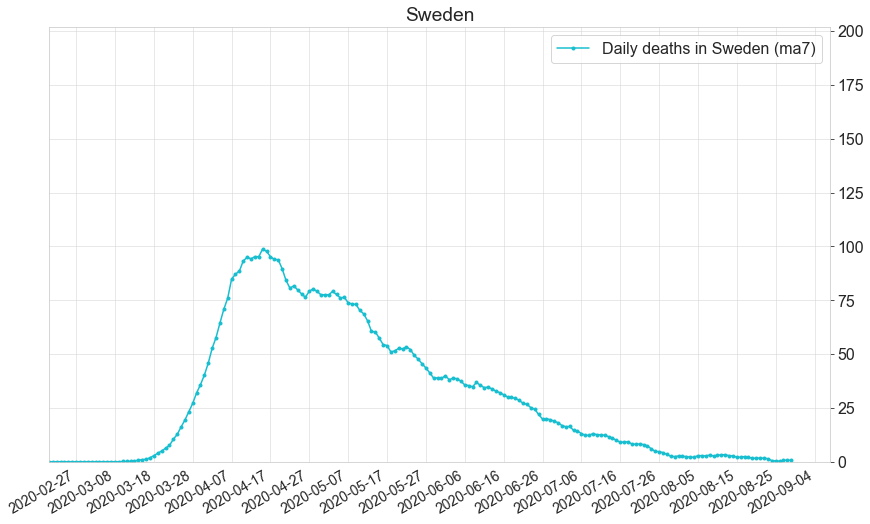

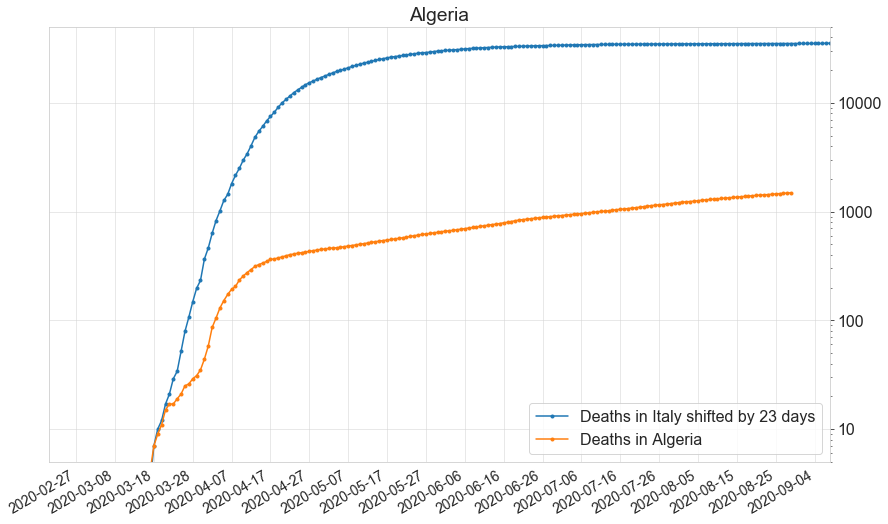

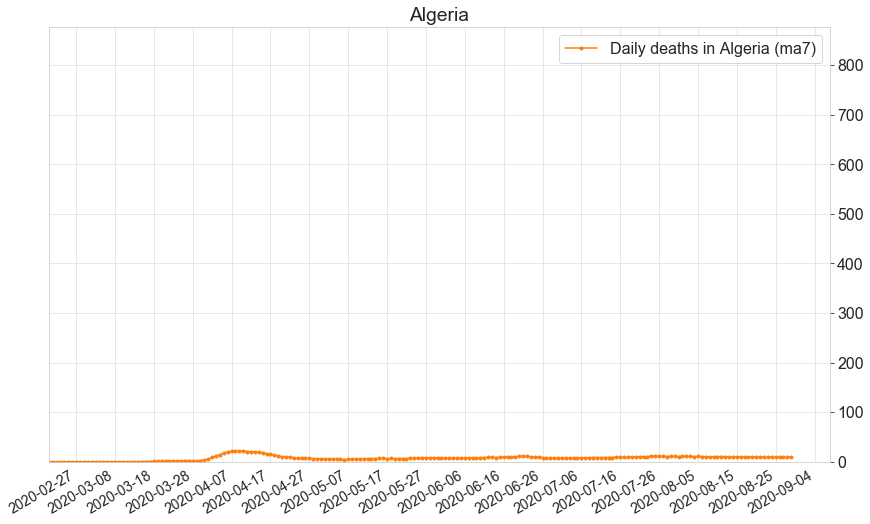

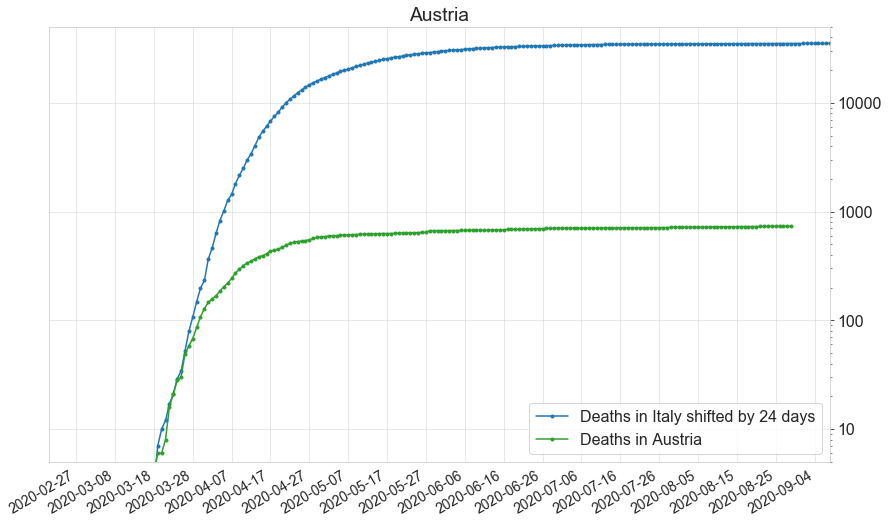

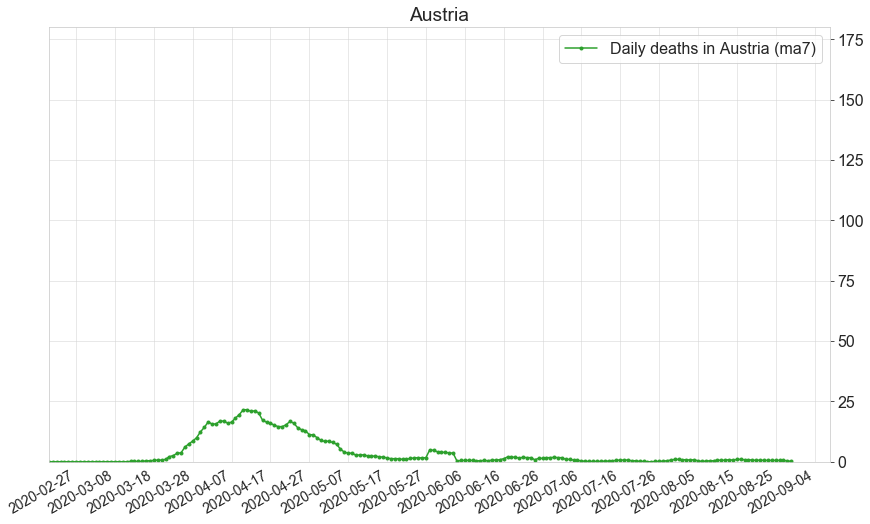

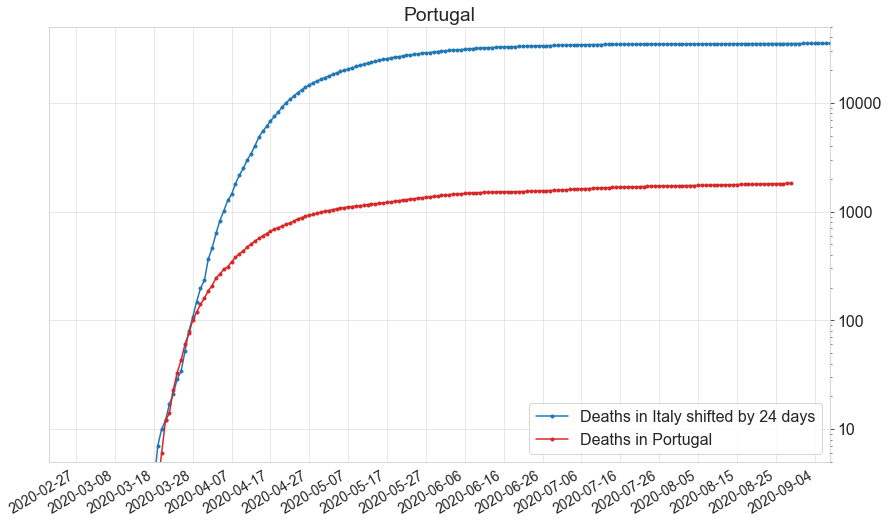

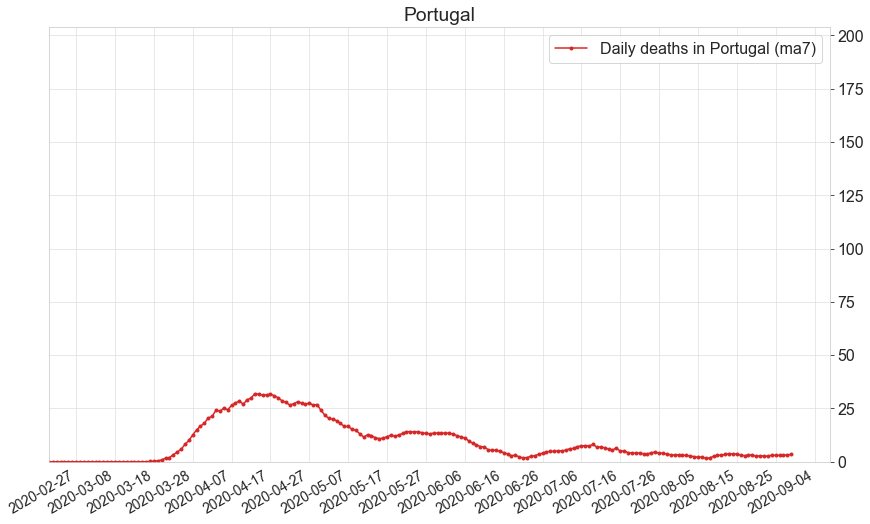

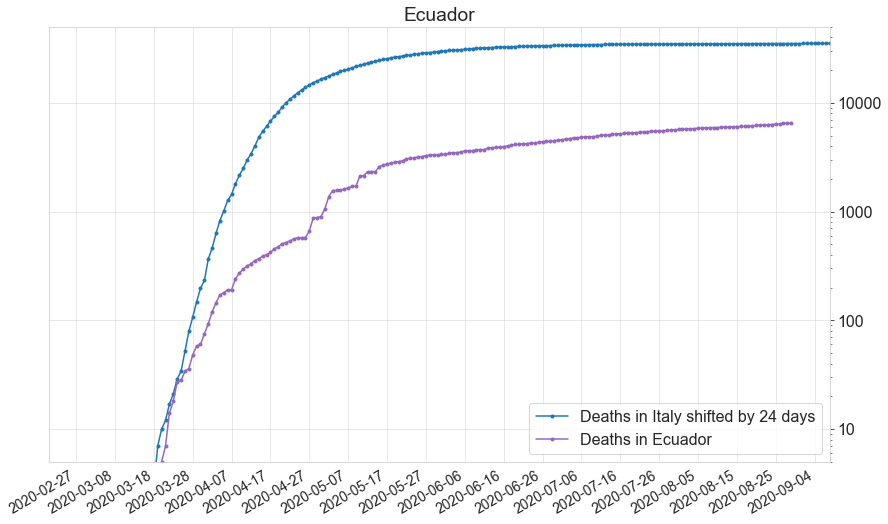

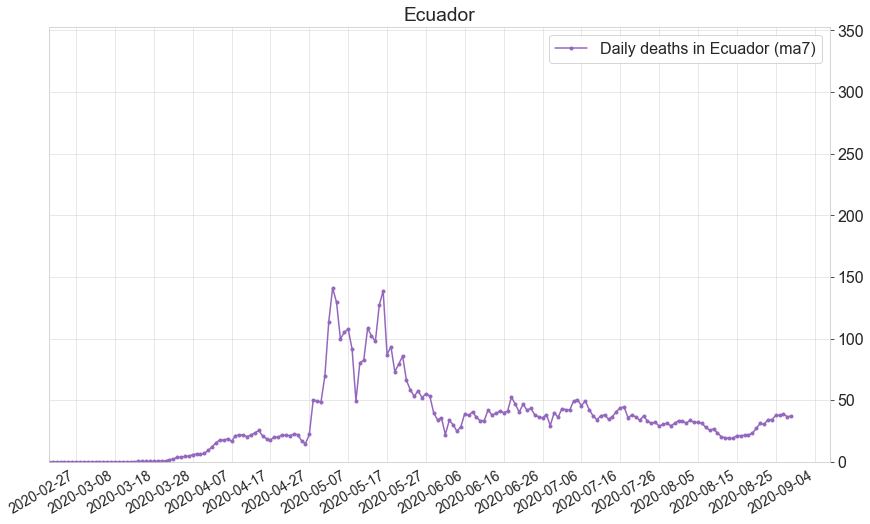

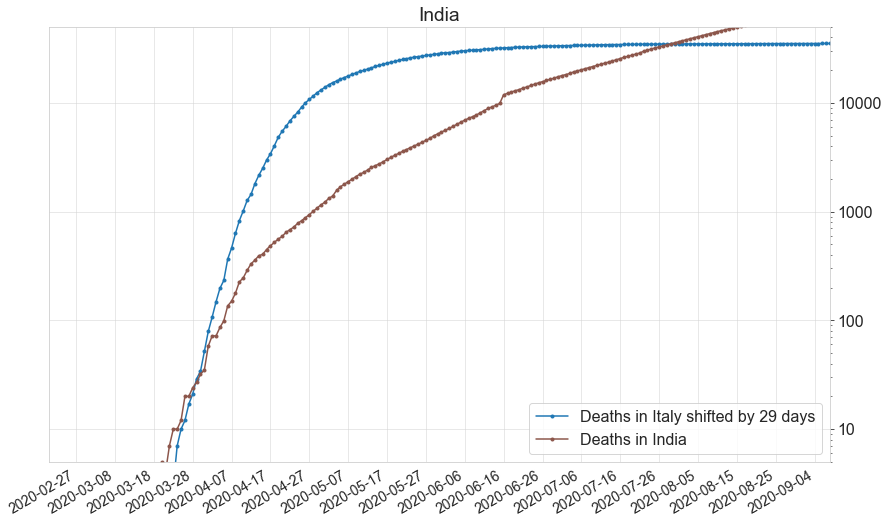

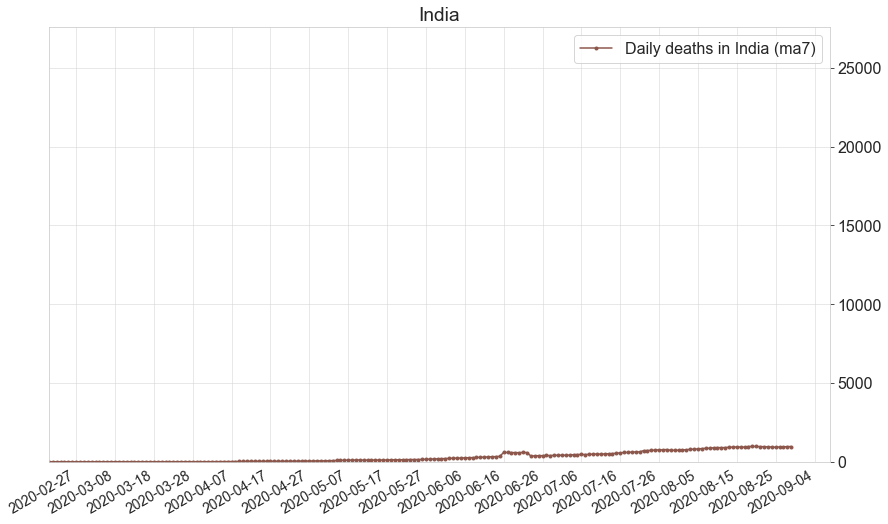

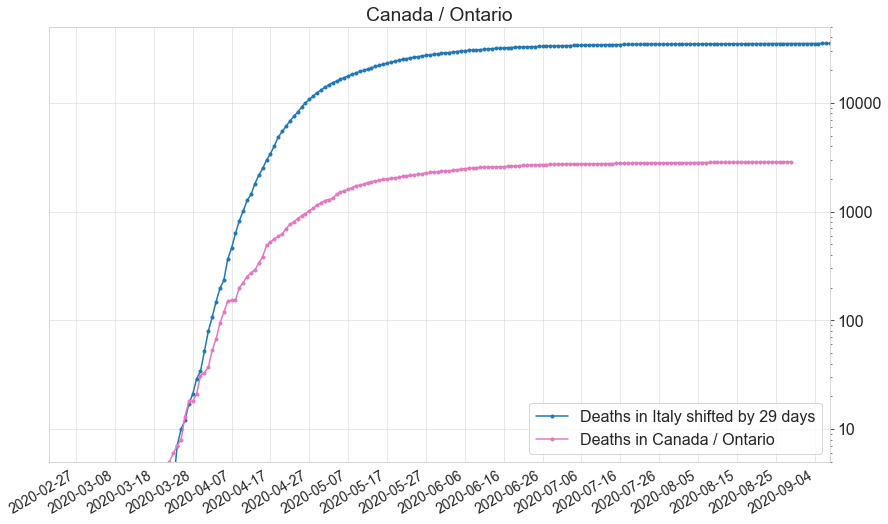

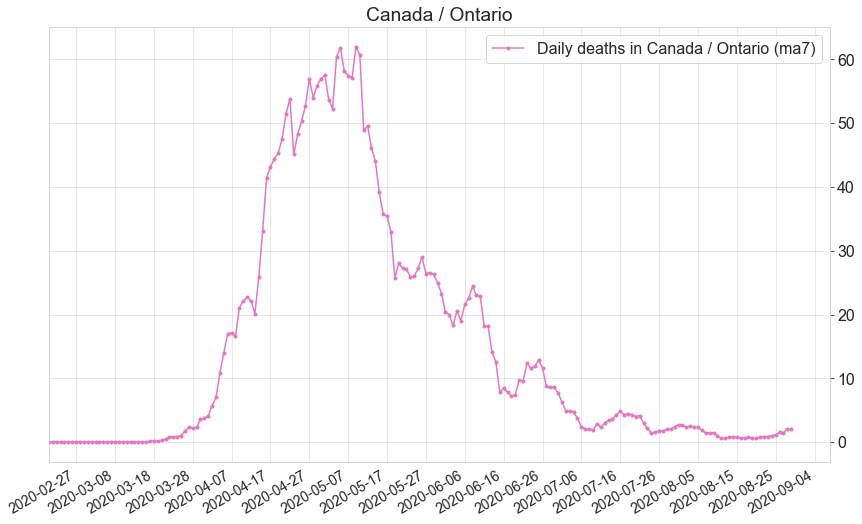

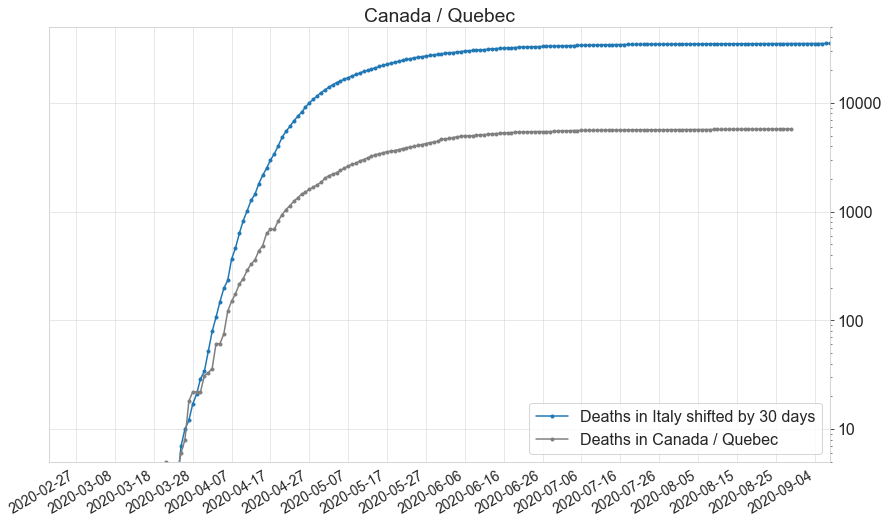

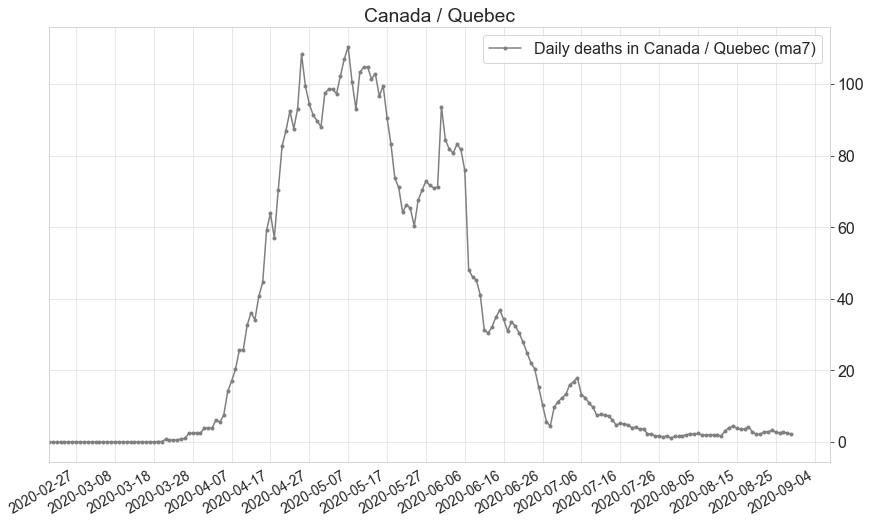

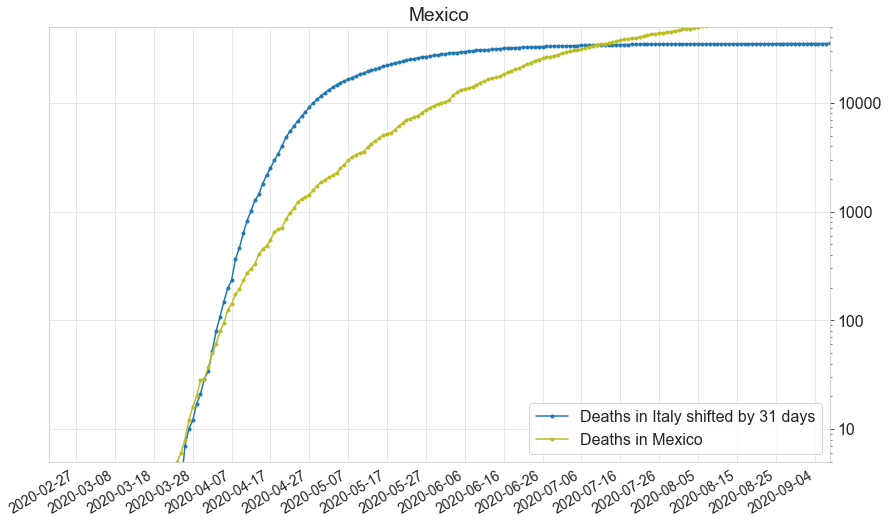

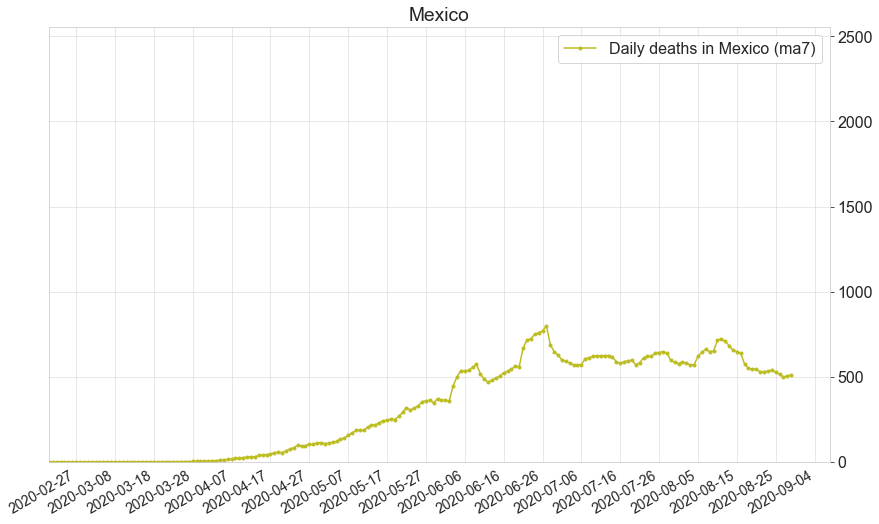

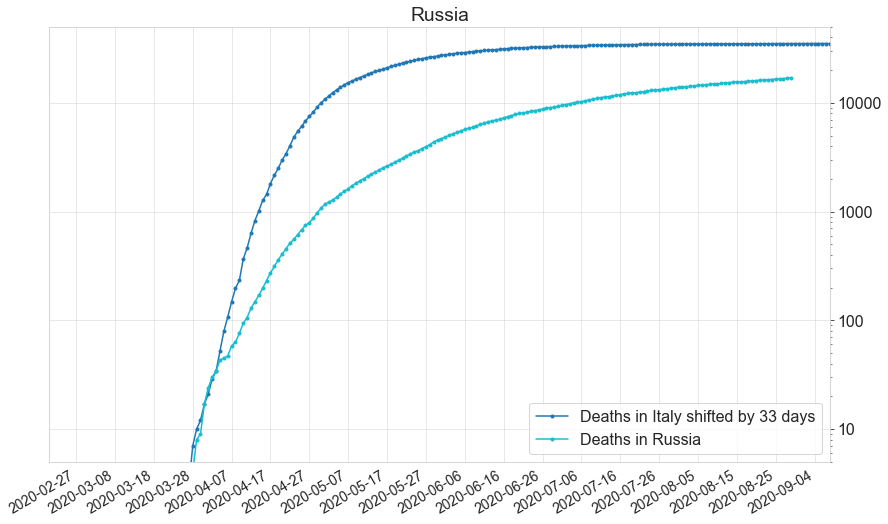

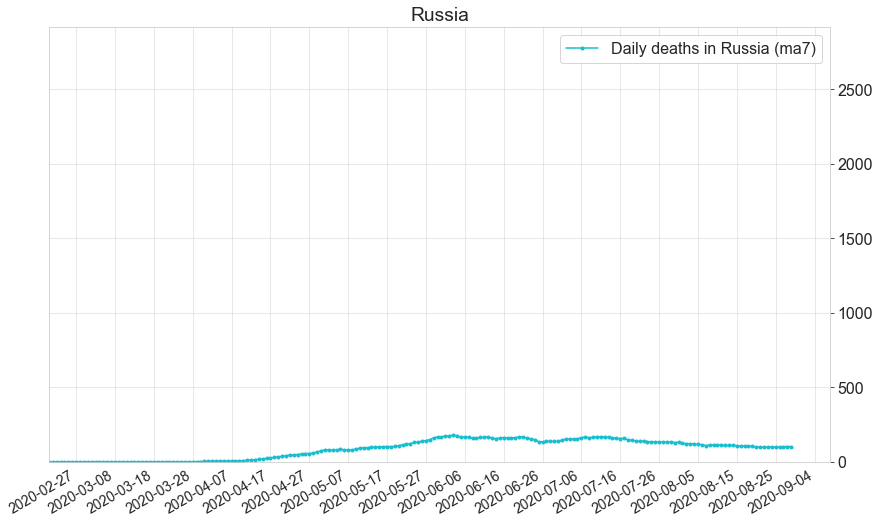

In [38]:
for (country, delay), color in list(zip(PARAMS.items(), itertools.cycle(PALETTE_ONE[1:]))):
    _, ax = covid19.plot.subplots(subplot_kw={
        'yscale': 'log',
        'ylim': (5, 50000),
        # 'ylim': (0, country_data[country]['deaths'].max() * 1.1),
        'xlim': XLIM,
    }, figsize=(14, 8))
    covid19.plot.plot_data(ax, world.sel(location='Italy')['deaths'], label=f'Deaths in Italy shifted by {delay} days', delay=delay, color=PALETTE_ONE[0])
    covid19.plot.plot_data(ax, world.sel(location=country)['deaths'], label=f'Deaths in {country}', color=color, date_interval=10)
    ax.set_title(f'{country}')
    ax.set(xlabel='', ylabel='')
    ax.legend()

    _, ax = covid19.plot.subplots(subplot_kw={
        # 'ylim': (1, 10000),
        # 'ylim': (0, country_data[country]['deaths'].max() * 1.1),
        'xlim': XLIM
    }, figsize=(14, 8))
    # covid19.plot.plot_data(ax, world.sel(location='Italy')['daily_deaths'].rolling({'time': 5}, center=True, min_periods=1).mean(), label=f'Daily deaths in Italy shifted by {delay} days', delay=delay, color=PALETTE_ONE[0])
    covid19.plot.plot_data(ax, world.sel(location=country)['daily_deaths7'], label=f'Daily deaths in {country} (ma7)', color=color, date_interval=10)
    ax.set_title(f'{country}')
    ax.set(xlabel='', ylabel='')
    ax.legend()
    try:
        ax.set(ylim=(0, world.sel(location=country).population.values / 50_000))
    except ValueError:
        pass